In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
from tqdm import tqdm
from PIL import Image

# Option 1: Simple CNN from scratch
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Option 2: Transfer Learning with ResNet
class ResNetTransfer(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetTransfer, self).__init__()
        # Load pretrained ResNet18
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)
        

# Example usage:
def main():
    # Create instances of both models
    simple_cnn = SimpleCNN(num_classes=10)
    resnet_transfer = ResNetTransfer(num_classes=10)
    
    # Print model summaries
    print("Simple CNN Architecture:")
    print(simple_cnn)
    print("\nResNet Transfer Learning Architecture:")
    print(resnet_transfer)

if __name__ == "__main__":
    main()

Simple CNN Architecture:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

ResNet Transfer Learning Architecture:
ResNetTransfer(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kern

In [33]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import os
from torch.utils.data import Dataset, DataLoader,  random_split

In [54]:
# Option 1: Simple CNN from scratch
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 21 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x
    
    def train_model(self, train_loader, num_epochs=10, lr=0.01):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        best_accuracy = 0.0

        for epoch in range(num_epochs):
            self.train()
            running_loss, correct, total = 0.0, 0, 0
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100, leave=True)

            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

            epoch_acc = 100 * correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {epoch_acc:.2f}%")

            if epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                torch.save(self.state_dict(), "best_model.pth")
                print("Model saved!")

    def evaluate_model(self, test_loader):
        self.eval()
        correct, total, test_loss = 0, 0, 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_accuracy = 100 * correct / total
        print(f"\n📊 Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")




In [36]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_to_idx =  {}

        # Assign class labels based on folder names
        class_folders = sorted(os.listdir(root_dir))
        for idx, class_name in enumerate(class_folders):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx # Assign a  label
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.data.append((img_path, idx))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
    
transform = transforms.Compose([
    transforms.Resize((168, 224)),  # Smaller images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

In [37]:
dataset_path = r'document_classification\document_classification'

full_dataset = CustomImageDataset(root_dir=dataset_path, transform=transform)

In [ ]:
# Split into train (80%) and test (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Check dataset structure
print(f"Classes: {full_dataset.class_to_idx}")
print(f"Total images: {len(full_dataset)}, Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Classes: {'email': 0, 'resume': 1, 'scientific_publication': 2}
Total images: 165, Train: 132, Test: 33


In [75]:
# Initialize model
num_classes = len(full_dataset.class_to_idx)  
model = SimpleCNN(num_classes)

# Train and Evaluate
model.train_model(train_loader, num_epochs=15, lr=0.001)
model.evaluate_model(test_loader)

Epoch 1/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  20%|██        | 1/5 [00:00<00:03,  1.28it/s, acc=40.6, loss=1.09]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  40%|████      | 2/5 [00:01<00:02,  1.24it/s, acc=39.1, loss=1.58]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  60%|██████    | 3/5 [00:02<00:01,  1.22it/s, acc=41.7, loss=1.04]

torch.Size([32, 64, 21, 28])


Epoch 1/15: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s, acc=38.6, loss=0.968]

torch.Size([4, 64, 21, 28])
Epoch [1/15], Loss: 1.2045, Accuracy: 38.64%


Model saved!


Epoch 2/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  20%|██        | 1/5 [00:00<00:03,  1.13it/s, acc=62.5, loss=1.02]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  40%|████      | 2/5 [00:01<00:02,  1.18it/s, acc=59.4, loss=0.959]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  60%|██████    | 3/5 [00:02<00:01,  1.27it/s, acc=61.5, loss=0.901]

torch.Size([32, 64, 21, 28])


Epoch 2/15: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s, acc=59.8, loss=1.21] 

torch.Size([4, 64, 21, 28])
Epoch [2/15], Loss: 0.9957, Accuracy: 59.85%


Model saved!


Epoch 3/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  20%|██        | 1/5 [00:00<00:03,  1.29it/s, acc=50, loss=0.924]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  40%|████      | 2/5 [00:01<00:02,  1.18it/s, acc=60.9, loss=0.721]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  60%|██████    | 3/5 [00:02<00:01,  1.20it/s, acc=62.5, loss=0.781]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  80%|████████  | 4/5 [00:03<00:00,  1.14it/s, acc=61.7, loss=0.843]

torch.Size([4, 64, 21, 28])


Epoch 3/15: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s, acc=60.6, loss=1.09] 


Epoch [3/15], Loss: 0.8710, Accuracy: 60.61%
Model saved!


Epoch 4/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  20%|██        | 1/5 [00:00<00:03,  1.28it/s, acc=53.1, loss=0.727]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  40%|████      | 2/5 [00:01<00:02,  1.31it/s, acc=60.9, loss=0.675]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  60%|██████    | 3/5 [00:02<00:01,  1.27it/s, acc=65.6, loss=0.506]

torch.Size([32, 64, 21, 28])


Epoch 4/15: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s, acc=64.4, loss=0.485]

torch.Size([4, 64, 21, 28])
Epoch [4/15], Loss: 0.6199, Accuracy: 64.39%


Model saved!


Epoch 5/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  20%|██        | 1/5 [00:00<00:02,  1.38it/s, acc=78.1, loss=0.432]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  40%|████      | 2/5 [00:01<00:02,  1.33it/s, acc=75, loss=0.643]  

torch.Size([32, 64, 21, 28])


Epoch 5/15:  60%|██████    | 3/5 [00:02<00:01,  1.35it/s, acc=79.2, loss=0.356]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  80%|████████  | 4/5 [00:03<00:00,  1.32it/s, acc=80.5, loss=0.456]

torch.Size([4, 64, 21, 28])


Epoch 5/15: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s, acc=79.5, loss=0.538]


Epoch [5/15], Loss: 0.4849, Accuracy: 79.55%
Model saved!


Epoch 6/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  20%|██        | 1/5 [00:00<00:03,  1.30it/s, acc=78.1, loss=0.363]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  40%|████      | 2/5 [00:01<00:02,  1.32it/s, acc=76.6, loss=0.538]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  60%|██████    | 3/5 [00:02<00:01,  1.31it/s, acc=81.2, loss=0.388]

torch.Size([32, 64, 21, 28])


Epoch 6/15: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s, acc=81.8, loss=0.476]

torch.Size([4, 64, 21, 28])
Epoch [6/15], Loss: 0.4455, Accuracy: 81.82%


Model saved!


Epoch 7/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  20%|██        | 1/5 [00:00<00:03,  1.29it/s, acc=90.6, loss=0.411]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  40%|████      | 2/5 [00:01<00:02,  1.26it/s, acc=87.5, loss=0.383]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  60%|██████    | 3/5 [00:02<00:01,  1.30it/s, acc=87.5, loss=0.535]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  80%|████████  | 4/5 [00:03<00:00,  1.32it/s, acc=88.3, loss=0.243]

torch.Size([4, 64, 21, 28])


Epoch 7/15: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s, acc=87.9, loss=0.825]


Epoch [7/15], Loss: 0.4796, Accuracy: 87.88%
Model saved!


Epoch 8/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  20%|██        | 1/5 [00:00<00:02,  1.36it/s, acc=90.6, loss=0.347]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  40%|████      | 2/5 [00:01<00:02,  1.23it/s, acc=93.8, loss=0.159]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  60%|██████    | 3/5 [00:02<00:01,  1.29it/s, acc=91.7, loss=0.371]

torch.Size([32, 64, 21, 28])


Epoch 8/15: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s, acc=90.9, loss=0.114]

torch.Size([4, 64, 21, 28])
Epoch [8/15], Loss: 0.2832, Accuracy: 90.91%


Model saved!


Epoch 9/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  20%|██        | 1/5 [00:00<00:03,  1.24it/s, acc=96.9, loss=0.148]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  40%|████      | 2/5 [00:01<00:02,  1.29it/s, acc=92.2, loss=0.322]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  60%|██████    | 3/5 [00:02<00:01,  1.26it/s, acc=89.6, loss=0.387]

torch.Size([32, 64, 21, 28])


Epoch 9/15: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s, acc=87.1, loss=0.296]


torch.Size([4, 64, 21, 28])
Epoch [9/15], Loss: 0.3074, Accuracy: 87.12%


Epoch 10/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  20%|██        | 1/5 [00:00<00:03,  1.33it/s, acc=90.6, loss=0.189]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  40%|████      | 2/5 [00:01<00:02,  1.21it/s, acc=89.1, loss=0.43] 

torch.Size([32, 64, 21, 28])


Epoch 10/15:  60%|██████    | 3/5 [00:02<00:01,  1.19it/s, acc=91.7, loss=0.114]

torch.Size([32, 64, 21, 28])


Epoch 10/15: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s, acc=90.2, loss=0.5]  


torch.Size([4, 64, 21, 28])
Epoch [10/15], Loss: 0.2956, Accuracy: 90.15%


Epoch 11/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  20%|██        | 1/5 [00:00<00:03,  1.07it/s, acc=90.6, loss=0.215]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  40%|████      | 2/5 [00:01<00:02,  1.10it/s, acc=95.3, loss=0.0912]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  60%|██████    | 3/5 [00:02<00:01,  1.18it/s, acc=95.8, loss=0.187] 

torch.Size([32, 64, 21, 28])


Epoch 11/15: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s, acc=96.2, loss=0.135]

torch.Size([4, 64, 21, 28])
Epoch [11/15], Loss: 0.1561, Accuracy: 96.21%


Model saved!


Epoch 12/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  20%|██        | 1/5 [00:00<00:03,  1.24it/s, acc=96.9, loss=0.244]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  40%|████      | 2/5 [00:01<00:02,  1.13it/s, acc=95.3, loss=0.161]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s, acc=94.8, loss=0.148]

torch.Size([32, 64, 21, 28])


Epoch 12/15: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s, acc=95.5, loss=0.081]


torch.Size([4, 64, 21, 28])
Epoch [12/15], Loss: 0.1522, Accuracy: 95.45%


Epoch 13/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  20%|██        | 1/5 [00:00<00:03,  1.28it/s, acc=93.8, loss=0.0935]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  40%|████      | 2/5 [00:01<00:02,  1.31it/s, acc=95.3, loss=0.0671]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  60%|██████    | 3/5 [00:02<00:01,  1.23it/s, acc=93.8, loss=0.132] 

torch.Size([32, 64, 21, 28])


Epoch 13/15: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s, acc=93.9, loss=0.0168]


torch.Size([4, 64, 21, 28])
Epoch [13/15], Loss: 0.1092, Accuracy: 93.94%


Epoch 14/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  20%|██        | 1/5 [00:00<00:03,  1.15it/s, acc=90.6, loss=0.175]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  40%|████      | 2/5 [00:01<00:02,  1.21it/s, acc=93.8, loss=0.12] 

torch.Size([32, 64, 21, 28])


Epoch 14/15:  60%|██████    | 3/5 [00:02<00:01,  1.24it/s, acc=95.8, loss=0.0134]

torch.Size([32, 64, 21, 28])


Epoch 14/15: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, acc=96.2, loss=0.00673]


torch.Size([4, 64, 21, 28])
Epoch [14/15], Loss: 0.0794, Accuracy: 96.21%


Epoch 15/15:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  20%|██        | 1/5 [00:00<00:03,  1.28it/s, acc=96.9, loss=0.0587]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  40%|████      | 2/5 [00:01<00:02,  1.22it/s, acc=96.9, loss=0.0488]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  60%|██████    | 3/5 [00:02<00:01,  1.18it/s, acc=96.9, loss=0.126] 

torch.Size([32, 64, 21, 28])


Epoch 15/15: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s, acc=97, loss=0.00119] 

torch.Size([4, 64, 21, 28])
Epoch [15/15], Loss: 0.0629, Accuracy: 96.97%


Model saved!
torch.Size([32, 64, 21, 28])
torch.Size([1, 64, 21, 28])

📊 Test Loss: 0.3793, Test Accuracy: 84.85%


# Let's try again but augumenting data 

In [74]:
import os
import cv2
import numpy as np
import random
from pathlib import Path

def random_rotate(image: np.ndarray,
                  min_angle: float,
                  max_angle: float) -> np.ndarray:
    """
    Randomly rotates the grayscale image by an angle between [min_angle, max_angle].
    Fills blank regions with white (255).
    """
    (height, width) = image.shape[:2] if image.ndim == 3 else image.shape
    angle = random.uniform(min_angle, max_angle)
    center = (width // 2, height // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(
        image, M, (width, height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=255  # White for a single-channel (grayscale) image
    )
    return rotated_image

def random_perspective(image: np.ndarray,
                       min_shift: float,
                       max_shift: float) -> np.ndarray:
    """
    Applies a random perspective transform in grayscale. Each corner can shift by
    a value in [min_shift, max_shift] in both x and y directions.
    Fills blank regions with white (255).
    """
    (height, width) = image.shape[:2] if image.ndim == 3 else image.shape

    src_pts = np.float32([
        [0,      0],
        [width,  0],
        [width,  height],
        [0,      height]
    ])
    
    dst_pts = []
    for (x, y) in src_pts:
        shift_x = random.uniform(min_shift, max_shift)
        shift_y = random.uniform(min_shift, max_shift)
        dst_pts.append([x + shift_x, y + shift_y])
    
    dst_pts = np.float32(dst_pts)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    warped_image = cv2.warpPerspective(
        image, M, (width, height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=255  # White for a single-channel (grayscale) image
    )
    return warped_image

def generate_augmented_images(image: np.ndarray,
                              min_angle: float,
                              max_angle: float,
                              min_perspective_shift: float,
                              max_perspective_shift: float,
                              num_images: int = 5) -> list:
    """
    Given a grayscale image (np.ndarray), returns a list of 'num_images' augmented images.
    Each augmented image is generated by randomly applying BOTH:
      - rotation (angle in [min_angle, max_angle])
      - perspective shift in [min_perspective_shift, max_perspective_shift]
    """
    augmented_images = []
    for _ in range(num_images):
        # Random rotation
        rotated = random_rotate(image, min_angle, max_angle)
        # Random perspective transform
        warped = random_perspective(rotated, min_perspective_shift, max_perspective_shift)
        augmented_images.append(warped)
    return augmented_images

def augment_dataset(root_folder: str,
                    min_angle=-30, max_angle=30,
                    min_shift=-20, max_shift=20,
                    num_augmented=10):
    """
    Walks through root_folder (recursively), and for each image found,
    generates 'num_augmented' new images, saved in the same folder (grayscale).
    Naming convention:
        originalname_augment_1.ext, originalname_augment_2.ext, ...
    Supported image extensions can be changed as needed.
    """
    
    # Define which file extensions to consider images
    valid_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tiff"}
    
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filename in filenames:
            ext = os.path.splitext(filename)[1].lower()
            if ext in valid_extensions:
                # Construct the full path
                image_path = os.path.join(dirpath, filename)
                
                # Read the image in grayscale
                image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image_gray is None:
                    print(f"Warning: Could not read {image_path}")
                    continue
                
                # Generate augmented images (grayscale in, grayscale out)
                augmented_images = generate_augmented_images(
                    image=image_gray,
                    min_angle=min_angle,
                    max_angle=max_angle,
                    min_perspective_shift=min_shift,
                    max_perspective_shift=max_shift,
                    num_images=num_augmented
                )
                
                # Save each augmented image
                original_name, ext_ = os.path.splitext(filename)
                for i, aug_img_gray in enumerate(augmented_images, start=1):
                    # Example naming: originalName_augment_1.jpg
                    new_filename = f"{original_name}_augment_{i}{ext_}"
                    new_filepath = os.path.join(dirpath, new_filename)
                    
                    # Save as grayscale
                    cv2.imwrite(new_filepath, aug_img_gray)
                    
                print(f"Augmented {filename} -> created {num_augmented} new images.")


In [76]:
folder_to_augment = r"document_classification\document_classification\email"
augment_dataset(root_folder=folder_to_augment,
            min_angle=-30, max_angle=30,
            min_shift=-20, max_shift=20,
            num_augmented=2)

folder_to_augment = r"document_classification\document_classification\resume"
augment_dataset(root_folder=folder_to_augment,
            min_angle=-30, max_angle=30,
            min_shift=-20, max_shift=20,
            num_augmented=2)

folder_to_augment = r"document_classification\document_classification\scientific_publication"
augment_dataset(root_folder=folder_to_augment,
            min_angle=-30, max_angle=30,
            min_shift=-20, max_shift=20,
            num_augmented=2)

Augmented doc_000042.png -> created 2 new images.
Augmented doc_000046.png -> created 2 new images.
Augmented doc_000076.png -> created 2 new images.
Augmented doc_000079.png -> created 2 new images.
Augmented doc_000111.png -> created 2 new images.
Augmented doc_000115.png -> created 2 new images.
Augmented doc_000133.png -> created 2 new images.
Augmented doc_000142.png -> created 2 new images.
Augmented doc_000148.png -> created 2 new images.
Augmented doc_000165.png -> created 2 new images.
Augmented doc_000195.png -> created 2 new images.
Augmented doc_000196.png -> created 2 new images.
Augmented doc_000238.png -> created 2 new images.
Augmented doc_000255.png -> created 2 new images.
Augmented doc_000260.png -> created 2 new images.
Augmented doc_000275.png -> created 2 new images.
Augmented doc_000278.png -> created 2 new images.
Augmented doc_000279.png -> created 2 new images.
Augmented doc_000282.png -> created 2 new images.
Augmented doc_000297.png -> created 2 new images.


In [78]:
dataset_path = r'document_classification\document_classification'

full_dataset = CustomImageDataset(root_dir=dataset_path, transform=transform)

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Check dataset structure
print(f"Classes: {full_dataset.class_to_idx}")
print(f"Total images: {len(full_dataset)}, Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Classes: {'email': 0, 'resume': 1, 'scientific_publication': 2}
Total images: 495, Train: 396, Test: 99


In [79]:
# Train and Evaluate
model.train_model(train_loader, num_epochs=15, lr=0.001)
model.evaluate_model(test_loader)

Epoch 1/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 1/15:   8%|▊         | 1/13 [00:01<00:12,  1.06s/it, acc=81.2, loss=1.11]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  15%|█▌        | 2/13 [00:02<00:11,  1.02s/it, acc=81.2, loss=1.31]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  23%|██▎       | 3/13 [00:02<00:09,  1.02it/s, acc=81.2, loss=0.781]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  31%|███       | 4/13 [00:03<00:08,  1.01it/s, acc=83.6, loss=0.313]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  38%|███▊      | 5/13 [00:04<00:07,  1.02it/s, acc=82.5, loss=0.578]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  46%|████▌     | 6/13 [00:05<00:06,  1.03it/s, acc=83.3, loss=0.346]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  54%|█████▍    | 7/13 [00:06<00:05,  1.03it/s, acc=83, loss=0.581]  

torch.Size([32, 64, 21, 28])


Epoch 1/15:  62%|██████▏   | 8/13 [00:07<00:05,  1.01s/it, acc=84, loss=0.723]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  69%|██████▉   | 9/13 [00:08<00:03,  1.00it/s, acc=84.4, loss=0.536]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  77%|███████▋  | 10/13 [00:09<00:03,  1.01s/it, acc=84.4, loss=0.372]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  85%|████████▍ | 11/13 [00:11<00:02,  1.03s/it, acc=84.1, loss=0.407]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  92%|█████████▏| 12/13 [00:12<00:01,  1.05s/it, acc=84.9, loss=0.3]  

torch.Size([12, 64, 21, 28])


Epoch 1/15: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s, acc=85.1, loss=0.388]


Epoch [1/15], Loss: 0.5957, Accuracy: 85.10%
Model saved!


Epoch 2/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 2/15:   8%|▊         | 1/13 [00:00<00:10,  1.18it/s, acc=90.6, loss=0.47]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  15%|█▌        | 2/13 [00:01<00:09,  1.12it/s, acc=90.6, loss=0.363]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  23%|██▎       | 3/13 [00:02<00:08,  1.19it/s, acc=87.5, loss=0.467]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  31%|███       | 4/13 [00:03<00:07,  1.22it/s, acc=85.9, loss=0.469]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  38%|███▊      | 5/13 [00:04<00:06,  1.22it/s, acc=85.6, loss=0.436]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  46%|████▌     | 6/13 [00:04<00:05,  1.22it/s, acc=85.9, loss=0.354]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  54%|█████▍    | 7/13 [00:05<00:04,  1.24it/s, acc=84.8, loss=0.491]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.24it/s, acc=86.3, loss=0.231]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.22it/s, acc=85.8, loss=0.341]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.23it/s, acc=86.2, loss=0.218]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.24it/s, acc=86.6, loss=0.321]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  92%|█████████▏| 12/13 [00:09<00:00,  1.25it/s, acc=87.5, loss=0.178]

torch.Size([12, 64, 21, 28])


Epoch 2/15: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s, acc=87.4, loss=0.292]


Epoch [2/15], Loss: 0.3562, Accuracy: 87.37%
Model saved!


Epoch 3/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 3/15:   8%|▊         | 1/13 [00:00<00:09,  1.27it/s, acc=93.8, loss=0.154]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  15%|█▌        | 2/13 [00:01<00:09,  1.12it/s, acc=92.2, loss=0.281]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  23%|██▎       | 3/13 [00:02<00:08,  1.15it/s, acc=93.8, loss=0.121]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  31%|███       | 4/13 [00:03<00:07,  1.19it/s, acc=90.6, loss=0.356]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  38%|███▊      | 5/13 [00:04<00:06,  1.21it/s, acc=90, loss=0.22]   

torch.Size([32, 64, 21, 28])


Epoch 3/15:  46%|████▌     | 6/13 [00:05<00:05,  1.18it/s, acc=90.6, loss=0.179]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.20it/s, acc=91.5, loss=0.141]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.19it/s, acc=90.2, loss=0.545]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.18it/s, acc=90.6, loss=0.188]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.18it/s, acc=90.3, loss=0.221]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.15it/s, acc=90.1, loss=0.316]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.19it/s, acc=90.6, loss=0.0839]

torch.Size([12, 64, 21, 28])


Epoch 3/15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, acc=90.7, loss=0.213] 


Epoch [3/15], Loss: 0.2322, Accuracy: 90.66%
Model saved!


Epoch 4/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 4/15:   8%|▊         | 1/13 [00:00<00:09,  1.21it/s, acc=96.9, loss=0.181]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, acc=96.9, loss=0.126]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  23%|██▎       | 3/13 [00:02<00:08,  1.17it/s, acc=97.9, loss=0.0681]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  31%|███       | 4/13 [00:03<00:07,  1.14it/s, acc=96.9, loss=0.108] 

torch.Size([32, 64, 21, 28])


Epoch 4/15:  38%|███▊      | 5/13 [00:04<00:06,  1.19it/s, acc=96.9, loss=0.152]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  46%|████▌     | 6/13 [00:05<00:05,  1.20it/s, acc=95.3, loss=0.289]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.20it/s, acc=95.1, loss=0.198]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.21it/s, acc=95.3, loss=0.106]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.22it/s, acc=93.8, loss=0.279]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.22it/s, acc=94.1, loss=0.133]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.23it/s, acc=94, loss=0.155]  

torch.Size([32, 64, 21, 28])


Epoch 4/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s, acc=94.3, loss=0.131]

torch.Size([12, 64, 21, 28])


Epoch 4/15: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s, acc=94.2, loss=0.2]  


Epoch [4/15], Loss: 0.1635, Accuracy: 94.19%
Model saved!


Epoch 5/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 5/15:   8%|▊         | 1/13 [00:00<00:09,  1.24it/s, acc=93.8, loss=0.226]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  15%|█▌        | 2/13 [00:01<00:09,  1.14it/s, acc=95.3, loss=0.114]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  23%|██▎       | 3/13 [00:02<00:08,  1.17it/s, acc=95.8, loss=0.107]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  31%|███       | 4/13 [00:03<00:07,  1.19it/s, acc=95.3, loss=0.163]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  38%|███▊      | 5/13 [00:04<00:06,  1.16it/s, acc=95.6, loss=0.101]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  46%|████▌     | 6/13 [00:05<00:06,  1.15it/s, acc=95.3, loss=0.172]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.18it/s, acc=94.6, loss=0.189]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.18it/s, acc=94.5, loss=0.0895]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.21it/s, acc=94.8, loss=0.102] 

torch.Size([32, 64, 21, 28])


Epoch 5/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.21it/s, acc=95.3, loss=0.0669]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.21it/s, acc=95.5, loss=0.0787]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.21it/s, acc=95.8, loss=0.0259]

torch.Size([12, 64, 21, 28])


Epoch 5/15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, acc=96, loss=0.0762]  


Epoch [5/15], Loss: 0.1162, Accuracy: 95.96%
Model saved!


Epoch 6/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 6/15:   8%|▊         | 1/13 [00:00<00:09,  1.22it/s, acc=100, loss=0.0232]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  15%|█▌        | 2/13 [00:01<00:09,  1.16it/s, acc=98.4, loss=0.0926]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  23%|██▎       | 3/13 [00:02<00:08,  1.17it/s, acc=94.8, loss=0.229] 

torch.Size([32, 64, 21, 28])


Epoch 6/15:  31%|███       | 4/13 [00:03<00:07,  1.15it/s, acc=96.1, loss=0.0422]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  38%|███▊      | 5/13 [00:04<00:06,  1.16it/s, acc=96.2, loss=0.0466]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  46%|████▌     | 6/13 [00:05<00:06,  1.16it/s, acc=96.4, loss=0.052] 

torch.Size([32, 64, 21, 28])


Epoch 6/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.18it/s, acc=96.9, loss=0.0409]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.18it/s, acc=97.3, loss=0.0362]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.14it/s, acc=97.6, loss=0.0351]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.17it/s, acc=96.9, loss=0.171]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.17it/s, acc=97.2, loss=0.0141]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s, acc=97.4, loss=0.0184]

torch.Size([12, 64, 21, 28])


Epoch 6/15: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s, acc=97.2, loss=0.129] 


Epoch [6/15], Loss: 0.0715, Accuracy: 97.22%
Model saved!


Epoch 7/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 7/15:   8%|▊         | 1/13 [00:00<00:10,  1.19it/s, acc=100, loss=0.0467]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  15%|█▌        | 2/13 [00:01<00:09,  1.16it/s, acc=98.4, loss=0.0474]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  23%|██▎       | 3/13 [00:02<00:08,  1.18it/s, acc=99, loss=0.0312]  

torch.Size([32, 64, 21, 28])


Epoch 7/15:  31%|███       | 4/13 [00:03<00:07,  1.16it/s, acc=99.2, loss=0.0158]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  38%|███▊      | 5/13 [00:04<00:06,  1.18it/s, acc=98.1, loss=0.107] 

torch.Size([32, 64, 21, 28])


Epoch 7/15:  46%|████▌     | 6/13 [00:05<00:06,  1.14it/s, acc=97.4, loss=0.072]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.17it/s, acc=97.8, loss=0.0292]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.18it/s, acc=97.7, loss=0.14]  

torch.Size([32, 64, 21, 28])


Epoch 7/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.18it/s, acc=97.9, loss=0.0595]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.19it/s, acc=98.1, loss=0.0271]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.20it/s, acc=98.3, loss=0.00479]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.20it/s, acc=98.4, loss=0.024]  

torch.Size([12, 64, 21, 28])


Epoch 7/15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, acc=98.5, loss=0.00439]


Epoch [7/15], Loss: 0.0469, Accuracy: 98.48%
Model saved!


Epoch 8/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 8/15:   8%|▊         | 1/13 [00:00<00:10,  1.10it/s, acc=100, loss=0.0242]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  15%|█▌        | 2/13 [00:01<00:09,  1.10it/s, acc=100, loss=0.00867]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  23%|██▎       | 3/13 [00:02<00:08,  1.15it/s, acc=100, loss=0.025]  

torch.Size([32, 64, 21, 28])


Epoch 8/15:  31%|███       | 4/13 [00:03<00:07,  1.16it/s, acc=100, loss=0.0114]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  38%|███▊      | 5/13 [00:04<00:06,  1.18it/s, acc=99.4, loss=0.0282]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  46%|████▌     | 6/13 [00:05<00:05,  1.19it/s, acc=99.5, loss=0.0135]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  54%|█████▍    | 7/13 [00:06<00:05,  1.14it/s, acc=99.6, loss=0.00811]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.17it/s, acc=99.2, loss=0.0397] 

torch.Size([32, 64, 21, 28])


Epoch 8/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.17it/s, acc=99.3, loss=0.00873]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.17it/s, acc=99.1, loss=0.0557]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.19it/s, acc=99.1, loss=0.0135]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.14it/s, acc=99.2, loss=0.0118]

torch.Size([12, 64, 21, 28])


Epoch 8/15: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, acc=99.2, loss=0.00296]


Epoch [8/15], Loss: 0.0193, Accuracy: 99.24%
Model saved!


Epoch 9/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 9/15:   8%|▊         | 1/13 [00:00<00:09,  1.24it/s, acc=100, loss=0.019]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  15%|█▌        | 2/13 [00:01<00:09,  1.16it/s, acc=100, loss=0.0148]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  23%|██▎       | 3/13 [00:02<00:08,  1.16it/s, acc=100, loss=0.00831]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  31%|███       | 4/13 [00:03<00:07,  1.17it/s, acc=100, loss=0.00767]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  38%|███▊      | 5/13 [00:04<00:06,  1.16it/s, acc=100, loss=0.00786]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  46%|████▌     | 6/13 [00:05<00:05,  1.17it/s, acc=100, loss=0.00887]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.19it/s, acc=100, loss=0.00338]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.19it/s, acc=100, loss=0.0125] 

torch.Size([32, 64, 21, 28])


Epoch 9/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.20it/s, acc=100, loss=0.00329]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.20it/s, acc=100, loss=0.00912]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.16it/s, acc=100, loss=0.000404]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s, acc=100, loss=0.019]   

torch.Size([12, 64, 21, 28])


Epoch 9/15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, acc=100, loss=0.000468]


Epoch [9/15], Loss: 0.0088, Accuracy: 100.00%
Model saved!


Epoch 10/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 10/15:   8%|▊         | 1/13 [00:00<00:09,  1.21it/s, acc=100, loss=0.00142]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  15%|█▌        | 2/13 [00:01<00:09,  1.14it/s, acc=100, loss=0.0173] 

torch.Size([32, 64, 21, 28])


Epoch 10/15:  23%|██▎       | 3/13 [00:02<00:09,  1.09it/s, acc=100, loss=0.00578]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  31%|███       | 4/13 [00:03<00:07,  1.14it/s, acc=100, loss=0.000689]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  38%|███▊      | 5/13 [00:04<00:06,  1.16it/s, acc=100, loss=0.00234] 

torch.Size([32, 64, 21, 28])


Epoch 10/15:  46%|████▌     | 6/13 [00:05<00:05,  1.17it/s, acc=100, loss=0.00121]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.19it/s, acc=100, loss=0.00462]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.14it/s, acc=100, loss=0.00104]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.17it/s, acc=100, loss=0.00312]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.19it/s, acc=100, loss=0.00331]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.17it/s, acc=100, loss=0.00236]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s, acc=100, loss=0.0147] 

torch.Size([12, 64, 21, 28])


Epoch 10/15: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, acc=100, loss=0.00614]


Epoch [10/15], Loss: 0.0049, Accuracy: 100.00%


Epoch 11/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 11/15:   8%|▊         | 1/13 [00:00<00:10,  1.17it/s, acc=100, loss=0.00233]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  15%|█▌        | 2/13 [00:01<00:09,  1.14it/s, acc=100, loss=0.00751]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  23%|██▎       | 3/13 [00:02<00:08,  1.18it/s, acc=100, loss=0.00531]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  31%|███       | 4/13 [00:03<00:07,  1.19it/s, acc=100, loss=0.000453]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  38%|███▊      | 5/13 [00:04<00:06,  1.20it/s, acc=100, loss=0.00362] 

torch.Size([32, 64, 21, 28])


Epoch 11/15:  46%|████▌     | 6/13 [00:05<00:05,  1.21it/s, acc=100, loss=0.00209]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  54%|█████▍    | 7/13 [00:05<00:04,  1.21it/s, acc=100, loss=0.00779]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.21it/s, acc=100, loss=0.00253]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.19it/s, acc=100, loss=0.00147]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.17it/s, acc=100, loss=0.01]  

torch.Size([32, 64, 21, 28])


Epoch 11/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.18it/s, acc=100, loss=0.00523]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.17it/s, acc=100, loss=0.00159]

torch.Size([12, 64, 21, 28])


Epoch 11/15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, acc=100, loss=0.000808]


Epoch [11/15], Loss: 0.0039, Accuracy: 100.00%


Epoch 12/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 12/15:   8%|▊         | 1/13 [00:00<00:09,  1.22it/s, acc=100, loss=0.0025]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  15%|█▌        | 2/13 [00:01<00:09,  1.22it/s, acc=100, loss=0.00315]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  23%|██▎       | 3/13 [00:02<00:08,  1.20it/s, acc=100, loss=0.00227]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  31%|███       | 4/13 [00:03<00:07,  1.14it/s, acc=100, loss=0.00358]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  38%|███▊      | 5/13 [00:04<00:06,  1.15it/s, acc=100, loss=0.00101]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  46%|████▌     | 6/13 [00:05<00:05,  1.17it/s, acc=100, loss=0.0041] 

torch.Size([32, 64, 21, 28])


Epoch 12/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.18it/s, acc=100, loss=0.00114]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.19it/s, acc=100, loss=0.000337]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.21it/s, acc=100, loss=0.00506] 

torch.Size([32, 64, 21, 28])


Epoch 12/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.20it/s, acc=100, loss=0.00151]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.18it/s, acc=100, loss=0.00392]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s, acc=100, loss=0.00707]

torch.Size([12, 64, 21, 28])


Epoch 12/15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, acc=100, loss=2.5e-5] 


Epoch [12/15], Loss: 0.0027, Accuracy: 100.00%


Epoch 13/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 13/15:   8%|▊         | 1/13 [00:00<00:10,  1.19it/s, acc=100, loss=0.00131]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  15%|█▌        | 2/13 [00:01<00:08,  1.22it/s, acc=100, loss=0.000578]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  23%|██▎       | 3/13 [00:02<00:08,  1.19it/s, acc=100, loss=0.00336] 

torch.Size([32, 64, 21, 28])


Epoch 13/15:  31%|███       | 4/13 [00:03<00:07,  1.21it/s, acc=100, loss=8.07e-5]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  38%|███▊      | 5/13 [00:04<00:06,  1.16it/s, acc=100, loss=0.00132]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  46%|████▌     | 6/13 [00:05<00:05,  1.18it/s, acc=100, loss=0.000274]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.19it/s, acc=99.6, loss=0.0326] 

torch.Size([32, 64, 21, 28])


Epoch 13/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.18it/s, acc=99.6, loss=0.000421]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.19it/s, acc=99.7, loss=0.00267] 

torch.Size([32, 64, 21, 28])


Epoch 13/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.20it/s, acc=99.7, loss=0.00134]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.19it/s, acc=99.7, loss=0.00562]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.20it/s, acc=99.7, loss=0.025]  

torch.Size([12, 64, 21, 28])


Epoch 13/15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, acc=99.7, loss=0.000445]


Epoch [13/15], Loss: 0.0058, Accuracy: 99.75%


Epoch 14/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 14/15:   8%|▊         | 1/13 [00:00<00:10,  1.18it/s, acc=100, loss=0.01]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  15%|█▌        | 2/13 [00:01<00:09,  1.20it/s, acc=100, loss=0.00299]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  23%|██▎       | 3/13 [00:02<00:08,  1.21it/s, acc=100, loss=0.00146]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  31%|███       | 4/13 [00:03<00:07,  1.18it/s, acc=100, loss=0.00561]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  38%|███▊      | 5/13 [00:04<00:06,  1.21it/s, acc=100, loss=0.00395]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  46%|████▌     | 6/13 [00:04<00:05,  1.20it/s, acc=100, loss=0.00306]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.14it/s, acc=100, loss=0.00666]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.15it/s, acc=100, loss=0.00106]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.17it/s, acc=100, loss=0.00865]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.18it/s, acc=99.7, loss=0.0785]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.19it/s, acc=99.7, loss=0.0011]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.17it/s, acc=99.7, loss=0.000832]

torch.Size([12, 64, 21, 28])


Epoch 14/15: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s, acc=99.7, loss=0.000914]


Epoch [14/15], Loss: 0.0096, Accuracy: 99.75%


Epoch 15/15:   0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 15/15:   8%|▊         | 1/13 [00:00<00:10,  1.10it/s, acc=100, loss=0.015]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  15%|█▌        | 2/13 [00:01<00:09,  1.15it/s, acc=98.4, loss=0.0604]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  23%|██▎       | 3/13 [00:02<00:08,  1.17it/s, acc=99, loss=0.0264]  

torch.Size([32, 64, 21, 28])


Epoch 15/15:  31%|███       | 4/13 [00:03<00:07,  1.19it/s, acc=98.4, loss=0.0442]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  38%|███▊      | 5/13 [00:04<00:06,  1.18it/s, acc=98.8, loss=0.00571]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  46%|████▌     | 6/13 [00:05<00:05,  1.19it/s, acc=99, loss=0.00615]  

torch.Size([32, 64, 21, 28])


Epoch 15/15:  54%|█████▍    | 7/13 [00:05<00:05,  1.20it/s, acc=98.7, loss=0.117]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  62%|██████▏   | 8/13 [00:06<00:04,  1.15it/s, acc=98.8, loss=0.0151]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  69%|██████▉   | 9/13 [00:07<00:03,  1.15it/s, acc=98.6, loss=0.0623]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  77%|███████▋  | 10/13 [00:08<00:02,  1.18it/s, acc=98.8, loss=0.00282]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  85%|████████▍ | 11/13 [00:09<00:01,  1.18it/s, acc=98.9, loss=0.00468]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  92%|█████████▏| 12/13 [00:10<00:00,  1.19it/s, acc=99, loss=0.0158]   

torch.Size([12, 64, 21, 28])


Epoch 15/15: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, acc=99, loss=0.0221]


Epoch [15/15], Loss: 0.0306, Accuracy: 98.99%
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([3, 64, 21, 28])

📊 Test Loss: 0.2131, Test Accuracy: 89.90%


After  augumentation we have an improvement of data  by 5%

# Let's try with Resnet

In [80]:
from torchvision import models

In [85]:
class ResNetTransfer(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetTransfer, self).__init__()
        
        # Load pretrained ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer with a custom one
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        return self.resnet(x)
    
    def unfreeze_last_few_layers(self, num_layers=3):
        """
        Unfreeze the last `num_layers` of the ResNet model to fine-tune them.
        """
        layers = list(self.resnet.children())[:-1]  # Exclude the final FC layer
        for layer in layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def train_model(self, train_loader, num_epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        best_accuracy = 0.0
        
        for epoch in range(num_epochs):
            self.train()
            running_loss, correct, total = 0.0, 0, 0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            epoch_acc = 100 * correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {epoch_acc:.2f}%")

            if epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                torch.save(self.state_dict(), "best_resnet_model.pth")
                print("Model saved!")

    def evaluate_model(self, test_loader):
        self.eval()
        correct, total, test_loss = 0, 0, 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_accuracy = 100 * correct / total
        print(f"\n📊 Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [86]:
# Initialize model
num_classes = len(full_dataset.class_to_idx)  
model = ResNetTransfer(num_classes)

In [87]:
model.unfreeze_last_few_layers(num_layers=3)

In [88]:
# Train and Evaluate
model.train_model(train_loader, num_epochs=15, lr=0.001)
model.evaluate_model(test_loader)

Epoch [1/15], Loss: 0.4498, Accuracy: 82.83%
Model saved!
Epoch [2/15], Loss: 0.1517, Accuracy: 94.95%
Model saved!
Epoch [3/15], Loss: 0.0622, Accuracy: 99.24%
Model saved!
Epoch [4/15], Loss: 0.0413, Accuracy: 98.99%
Epoch [5/15], Loss: 0.0229, Accuracy: 99.24%
Epoch [6/15], Loss: 0.0049, Accuracy: 100.00%
Model saved!
Epoch [7/15], Loss: 0.0038, Accuracy: 100.00%
Epoch [8/15], Loss: 0.0105, Accuracy: 99.75%
Epoch [9/15], Loss: 0.0285, Accuracy: 99.24%
Epoch [10/15], Loss: 0.0062, Accuracy: 100.00%
Epoch [11/15], Loss: 0.0047, Accuracy: 100.00%
Epoch [12/15], Loss: 0.0028, Accuracy: 100.00%
Epoch [13/15], Loss: 0.0009, Accuracy: 100.00%
Epoch [14/15], Loss: 0.0016, Accuracy: 100.00%
Epoch [15/15], Loss: 0.0004, Accuracy: 100.00%

📊 Test Loss: 0.0773, Test Accuracy: 96.97%


# Use convolutional activation maps

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image

In [6]:
model = SimpleCNN(num_classes=3)

In [7]:
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
model.eval()

C:\Users\crist\AppData\Local\Temp\ipykernel_26520\2241164722.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=37632, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
layer_name = "conv3"
activation = {}

In [25]:
# Hook function to store the activation output
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()  # Store feature map
    return hook

# Register hook to capture feature maps from the chosen layer
model.conv1.register_forward_hook(get_activation(layer_name))

In [26]:
# Image transformation for ResNet input
transform = transforms.Compose([
    transforms.Resize((168, 224)),  # Smaller images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

In [27]:
# Load an example image
image_path = r"document_classification\document_classification\email\doc_000825.png"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

torch.Size([1, 64, 21, 28])


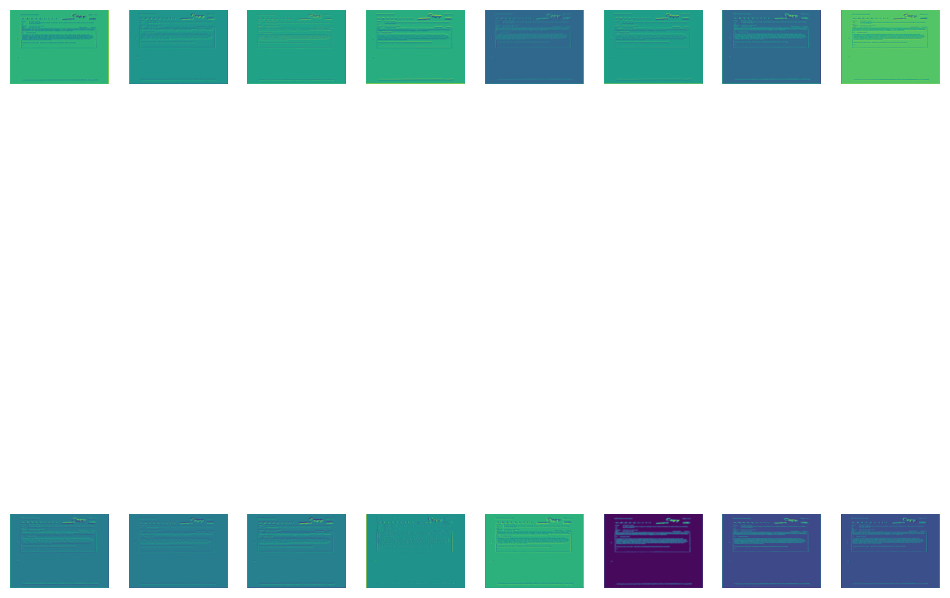

In [28]:
# Forward pass through the model
output = model(input_tensor)

# Get the feature maps
feature_maps = activation[layer_name].squeeze(0)  # Remove batch dimension

# Function to visualize activation maps
def plot_feature_maps(feature_maps, num_cols=8):
    num_features = feature_maps.shape[0]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_features):
        ax = axes[i]
        ax.imshow(feature_maps[i].cpu().numpy(), cmap="viridis")
        ax.axis("off")

    # Hide unused subplots
    for i in range(num_features, len(axes)):
        axes[i].axis("off")

    plt.show()

# Visualize the activation maps
plot_feature_maps(feature_maps)

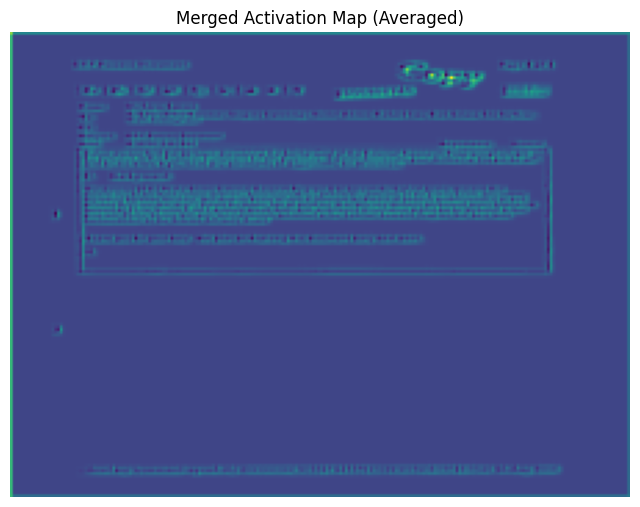

In [29]:
# Compute the mean activation across all feature maps
merged_feature_map = feature_maps.mean(dim=0).cpu().numpy()

# Plot the single merged activation map
plt.figure(figsize=(8, 8))
plt.imshow(merged_feature_map, cmap="viridis")
plt.axis("off")
plt.title("Merged Activation Map (Averaged)")
plt.show()

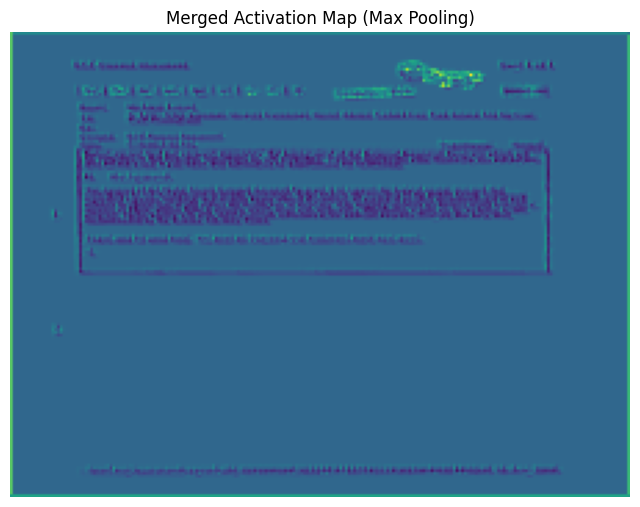

In [30]:
# Compute the max activation across all feature maps
merged_feature_map = feature_maps.max(dim=0)[0].cpu().numpy()

# Plot the single merged activation map
plt.figure(figsize=(8, 8))
plt.imshow(merged_feature_map, cmap="viridis")
plt.axis("off")
plt.title("Merged Activation Map (Max Pooling)")
plt.show()


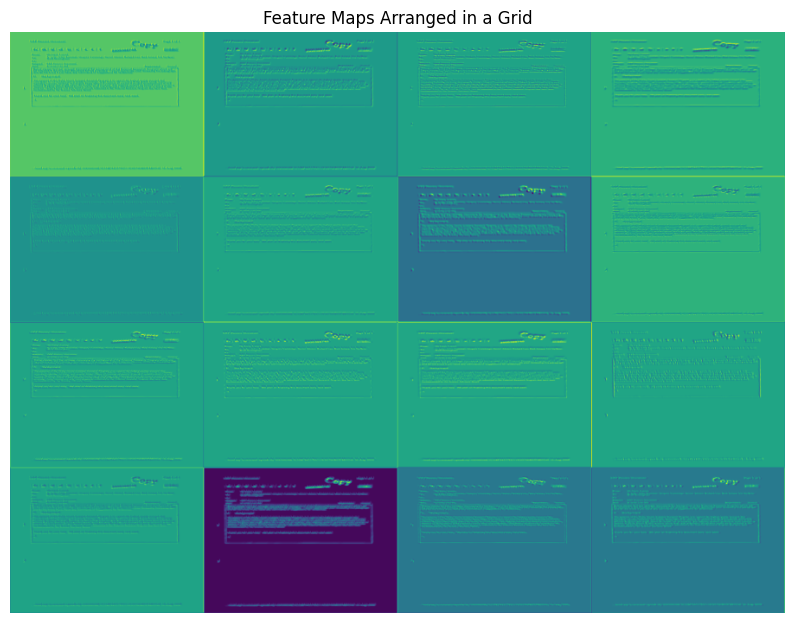

In [31]:
# Define grid size (e.g., 4x4 for 16 maps)
num_features = feature_maps.shape[0]
grid_size = int(np.ceil(np.sqrt(num_features)))  # Closest square grid

# Create a blank canvas
h, w = feature_maps.shape[1], feature_maps.shape[2]
grid_image = np.zeros((h * grid_size, w * grid_size))

# Fill the grid with feature maps
for i in range(num_features):
    row = i // grid_size
    col = i % grid_size
    grid_image[row * h : (row + 1) * h, col * w : (col + 1) * w] = feature_maps[i].cpu().numpy()

# Plot the final grid
plt.figure(figsize=(10, 10))
plt.imshow(grid_image, cmap="viridis")
plt.axis("off")
plt.title("Feature Maps Arranged in a Grid")
plt.show()


Let's display Fully Connected layer

In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_saliency_map(model, image, target_class):
    image = image.unsqueeze(0).requires_grad_()  # Add batch dimension and enable gradients

    model.eval()
    output = model(image)  # Forward pass

    # Get the output score for the target class
    score = output[0, target_class]

    # Backpropagate the gradients
    model.zero_grad()
    score.backward()

    # Get the absolute value of the gradients (importance)
    saliency = image.grad.abs().squeeze().detach().cpu().numpy()

    # Normalize the values for visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Show the saliency map
    plt.imshow(saliency.transpose(1, 2, 0))  # Transpose to (H, W, C)
    plt.axis("off")
    plt.title(f"Saliency Map for Class {target_class}")
    plt.show()

torch.Size([1, 64, 21, 28])


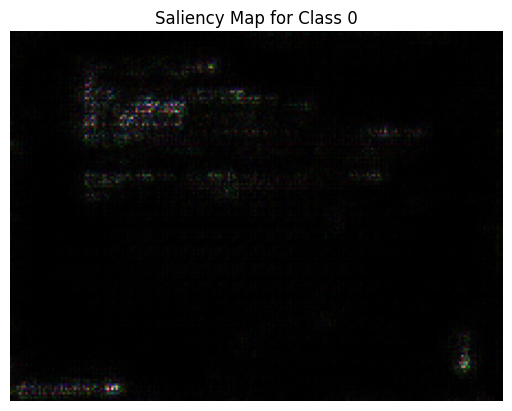

In [38]:
# Example usage
image, label = full_dataset[0]  # Get an image from your dataset
generate_saliency_map(model, image, target_class=0)


# Try again

I added two new classes - dogs and  cats.  Now I want to train again the Model, and see salience map on these two new class

In [55]:
dataset_path = r'document_classification\document_classification'

full_dataset = CustomImageDataset(root_dir=dataset_path, transform=transform)

In [56]:
model = SimpleCNN(num_classes=5)

In [57]:
# Split into train (80%) and test (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Check dataset structure
print(f"Classes: {full_dataset.class_to_idx}")
print(f"Total images: {len(full_dataset)}, Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Classes: {'cats': 0, 'dogs': 1, 'email': 2, 'resume': 3, 'scientific_publication': 4}
Total images: 2165, Train: 1732, Test: 433


In [58]:
# Train and Evaluate
model.train_model(train_loader, num_epochs=15, lr=0.001)
model.evaluate_model(test_loader)

Epoch 1/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 1/15:   2%|▌                                 | 1/55 [00:00<00:45,  1.19it/s, acc=0, loss=1.63]

torch.Size([32, 64, 21, 28])


Epoch 1/15:   4%|█▏                             | 2/55 [00:01<00:43,  1.21it/s, acc=23.4, loss=1.06]

torch.Size([32, 64, 21, 28])


Epoch 1/15:   5%|█▋                              | 3/55 [00:02<00:44,  1.16it/s, acc=32.3, loss=1.5]

torch.Size([32, 64, 21, 28])


Epoch 1/15:   7%|██▍                               | 4/55 [00:03<00:43,  1.17it/s, acc=39.1, loss=1]

torch.Size([32, 64, 21, 28])


Epoch 1/15:   9%|██▉                             | 5/55 [00:04<00:43,  1.14it/s, acc=40, loss=0.918]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  11%|███▍                           | 6/55 [00:05<00:43,  1.12it/s, acc=38.5, loss=1.07]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  13%|███▊                          | 7/55 [00:06<00:41,  1.15it/s, acc=40.2, loss=0.889]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  15%|████▋                           | 8/55 [00:06<00:40,  1.17it/s, acc=41, loss=0.919]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  16%|████▉                         | 9/55 [00:07<00:38,  1.20it/s, acc=41.3, loss=0.827]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  18%|█████▍                        | 10/55 [00:08<00:37,  1.19it/s, acc=40.6, loss=0.91]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  20%|█████▊                       | 11/55 [00:09<00:36,  1.21it/s, acc=41.8, loss=0.773]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  22%|██████▎                      | 12/55 [00:10<00:35,  1.20it/s, acc=41.7, loss=0.909]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  24%|██████▊                      | 13/55 [00:11<00:35,  1.19it/s, acc=42.5, loss=0.839]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  25%|███████▉                       | 14/55 [00:11<00:34,  1.19it/s, acc=44, loss=0.696]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  27%|████████▍                      | 15/55 [00:12<00:34,  1.15it/s, acc=44, loss=0.981]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  29%|████████▍                    | 16/55 [00:13<00:33,  1.16it/s, acc=44.1, loss=0.818]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  31%|████████▉                    | 17/55 [00:14<00:32,  1.19it/s, acc=44.9, loss=0.807]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  33%|█████████▍                   | 18/55 [00:15<00:31,  1.19it/s, acc=45.5, loss=0.779]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  35%|██████████                   | 19/55 [00:16<00:30,  1.17it/s, acc=44.9, loss=0.838]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  36%|██████████▌                  | 20/55 [00:16<00:29,  1.18it/s, acc=45.5, loss=0.815]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  38%|███████████▍                  | 21/55 [00:17<00:29,  1.16it/s, acc=45.7, loss=0.81]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  40%|███████████▌                 | 22/55 [00:18<00:28,  1.16it/s, acc=45.7, loss=0.816]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  42%|████████████▏                | 23/55 [00:19<00:27,  1.15it/s, acc=45.9, loss=0.803]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  44%|█████████████▌                 | 24/55 [00:20<00:26,  1.18it/s, acc=47, loss=0.683]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  45%|█████████████▏               | 25/55 [00:21<00:24,  1.20it/s, acc=46.9, loss=0.769]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  47%|█████████████▋               | 26/55 [00:22<00:24,  1.18it/s, acc=46.9, loss=0.851]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  49%|██████████████▏              | 27/55 [00:22<00:23,  1.17it/s, acc=46.6, loss=0.821]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  51%|██████████████▊              | 28/55 [00:23<00:23,  1.15it/s, acc=46.5, loss=0.761]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  53%|████████████████▎              | 29/55 [00:24<00:22,  1.15it/s, acc=47, loss=0.753]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  55%|███████████████▊             | 30/55 [00:25<00:21,  1.16it/s, acc=47.1, loss=0.779]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  56%|████████████████▎            | 31/55 [00:26<00:21,  1.14it/s, acc=47.2, loss=0.804]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  58%|████████████████▊            | 32/55 [00:27<00:20,  1.15it/s, acc=47.7, loss=0.763]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  60%|█████████████████▍           | 33/55 [00:28<00:19,  1.14it/s, acc=47.7, loss=0.953]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  62%|██████████████████▌           | 34/55 [00:29<00:19,  1.09it/s, acc=47.2, loss=0.99]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  64%|██████████████████▍          | 35/55 [00:30<00:18,  1.11it/s, acc=47.1, loss=0.861]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  65%|████████████████████▎          | 36/55 [00:31<00:17,  1.11it/s, acc=47, loss=0.767]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  67%|███████████████████▌         | 37/55 [00:31<00:15,  1.13it/s, acc=47.6, loss=0.766]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  69%|████████████████████         | 38/55 [00:32<00:14,  1.14it/s, acc=47.7, loss=0.762]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  71%|████████████████████▌        | 39/55 [00:33<00:13,  1.17it/s, acc=47.7, loss=0.727]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  73%|█████████████████████        | 40/55 [00:34<00:13,  1.14it/s, acc=47.8, loss=0.747]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  75%|█████████████████████▌       | 41/55 [00:35<00:12,  1.15it/s, acc=47.8, loss=0.808]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  76%|██████████████████████▏      | 42/55 [00:36<00:11,  1.15it/s, acc=48.1, loss=0.703]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  78%|██████████████████████▋      | 43/55 [00:37<00:10,  1.14it/s, acc=48.5, loss=0.766]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  80%|███████████████████████▏     | 44/55 [00:37<00:09,  1.14it/s, acc=48.4, loss=0.734]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  82%|███████████████████████▋     | 45/55 [00:38<00:08,  1.16it/s, acc=48.5, loss=0.766]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  84%|████████████████████████▎    | 46/55 [00:41<00:12,  1.40s/it, acc=48.3, loss=0.841]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  85%|████████████████████████▊    | 47/55 [00:42<00:09,  1.24s/it, acc=48.6, loss=0.704]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  87%|█████████████████████████▎   | 48/55 [00:43<00:07,  1.10s/it, acc=48.9, loss=0.661]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  89%|█████████████████████████▊   | 49/55 [00:43<00:06,  1.04s/it, acc=48.9, loss=0.781]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  91%|██████████████████████████▎  | 50/55 [00:44<00:04,  1.03it/s, acc=48.6, loss=0.884]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  93%|██████████████████████████▉  | 51/55 [00:45<00:03,  1.03it/s, acc=48.7, loss=0.741]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  95%|███████████████████████████▍ | 52/55 [00:46<00:02,  1.07it/s, acc=48.7, loss=0.766]

torch.Size([32, 64, 21, 28])


Epoch 1/15:  96%|███████████████████████████▉ | 53/55 [00:47<00:01,  1.11it/s, acc=48.7, loss=0.776]

torch.Size([32, 64, 21, 28])


Epoch 1/15: 100%|█████████████████████████████| 55/55 [00:48<00:00,  1.13it/s, acc=48.8, loss=0.918]

torch.Size([4, 64, 21, 28])
Epoch [1/15], Loss: 0.8471, Accuracy: 48.79%


Model saved!


Epoch 2/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 2/15:   2%|▌                             | 1/55 [00:00<00:31,  1.69it/s, acc=65.6, loss=0.685]

torch.Size([32, 64, 21, 28])


Epoch 2/15:   4%|█                             | 2/55 [00:01<00:31,  1.69it/s, acc=59.4, loss=0.676]

torch.Size([32, 64, 21, 28])


Epoch 2/15:   5%|█▋                            | 3/55 [00:01<00:35,  1.47it/s, acc=55.2, loss=0.832]

torch.Size([32, 64, 21, 28])


Epoch 2/15:   7%|██▏                           | 4/55 [00:02<00:32,  1.56it/s, acc=57.8, loss=0.678]

torch.Size([32, 64, 21, 28])


Epoch 2/15:   9%|██▋                           | 5/55 [00:03<00:31,  1.57it/s, acc=58.1, loss=0.704]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  11%|███▎                          | 6/55 [00:03<00:29,  1.63it/s, acc=59.4, loss=0.673]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  13%|███▊                          | 7/55 [00:04<00:28,  1.66it/s, acc=56.7, loss=0.766]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  15%|████▎                         | 8/55 [00:07<01:08,  1.46s/it, acc=56.6, loss=0.734]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  16%|█████▏                          | 9/55 [00:08<00:56,  1.23s/it, acc=58, loss=0.678]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  18%|█████▎                       | 10/55 [00:08<00:46,  1.04s/it, acc=56.9, loss=0.842]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  20%|█████▊                       | 11/55 [00:09<00:39,  1.11it/s, acc=58.2, loss=0.647]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  22%|██████▎                      | 12/55 [00:10<00:35,  1.21it/s, acc=57.8, loss=0.752]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  24%|██████▊                      | 13/55 [00:10<00:33,  1.26it/s, acc=58.7, loss=0.673]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  25%|███████▍                     | 14/55 [00:11<00:32,  1.26it/s, acc=57.8, loss=0.699]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  27%|███████▉                     | 15/55 [00:12<00:29,  1.36it/s, acc=57.7, loss=0.739]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  29%|████████▍                    | 16/55 [00:12<00:27,  1.44it/s, acc=58.8, loss=0.639]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  31%|█████████▎                    | 17/55 [00:13<00:25,  1.48it/s, acc=58.8, loss=0.67]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  33%|█████████▍                   | 18/55 [00:14<00:24,  1.49it/s, acc=58.9, loss=0.769]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  35%|██████████▋                    | 19/55 [00:14<00:23,  1.51it/s, acc=59, loss=0.672]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  36%|██████████▉                   | 20/55 [00:15<00:23,  1.50it/s, acc=59.2, loss=0.64]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  38%|███████████                  | 21/55 [00:16<00:22,  1.49it/s, acc=59.1, loss=0.707]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  40%|████████████                  | 22/55 [00:16<00:23,  1.43it/s, acc=59.2, loss=0.59]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  42%|████████████▏                | 23/55 [00:17<00:22,  1.43it/s, acc=59.8, loss=0.595]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  44%|█████████████                 | 24/55 [00:18<00:20,  1.49it/s, acc=59.5, loss=0.71]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  45%|█████████████▏               | 25/55 [00:18<00:19,  1.50it/s, acc=59.2, loss=0.735]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  47%|█████████████▋               | 26/55 [00:19<00:19,  1.52it/s, acc=58.9, loss=0.728]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  49%|███████████████▏               | 27/55 [00:20<00:18,  1.53it/s, acc=59, loss=0.709]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  51%|███████████████▎              | 28/55 [00:20<00:17,  1.57it/s, acc=59.3, loss=0.65]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  53%|███████████████▎             | 29/55 [00:21<00:16,  1.55it/s, acc=60.1, loss=0.571]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  55%|███████████████▊             | 30/55 [00:22<00:16,  1.50it/s, acc=60.2, loss=0.724]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  56%|█████████████████▍             | 31/55 [00:22<00:16,  1.48it/s, acc=60, loss=0.707]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  58%|████████████████▊            | 32/55 [00:23<00:15,  1.53it/s, acc=59.8, loss=0.769]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  60%|█████████████████▍           | 33/55 [00:24<00:14,  1.53it/s, acc=59.5, loss=0.926]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  62%|█████████████████▉           | 34/55 [00:24<00:13,  1.54it/s, acc=59.1, loss=0.713]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  64%|██████████████████▍          | 35/55 [00:25<00:14,  1.34it/s, acc=59.2, loss=0.638]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  65%|██████████████████▉          | 36/55 [00:27<00:22,  1.16s/it, acc=59.2, loss=0.629]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  67%|████████████████████▊          | 37/55 [00:28<00:17,  1.00it/s, acc=59, loss=0.895]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  69%|████████████████████         | 38/55 [00:29<00:15,  1.09it/s, acc=59.2, loss=0.674]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  71%|████████████████████▌        | 39/55 [00:29<00:13,  1.17it/s, acc=59.2, loss=0.715]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  73%|█████████████████████        | 40/55 [00:30<00:12,  1.24it/s, acc=59.3, loss=0.662]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  75%|█████████████████████▌       | 41/55 [00:31<00:10,  1.29it/s, acc=59.6, loss=0.585]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  76%|██████████████████████▉       | 42/55 [00:32<00:09,  1.30it/s, acc=59.3, loss=0.76]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  78%|██████████████████████▋      | 43/55 [00:32<00:08,  1.34it/s, acc=59.3, loss=0.727]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  80%|███████████████████████▏     | 44/55 [00:33<00:07,  1.39it/s, acc=59.3, loss=0.692]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  82%|███████████████████████▋     | 45/55 [00:34<00:06,  1.47it/s, acc=59.6, loss=0.601]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  84%|████████████████████████▎    | 46/55 [00:36<00:11,  1.24s/it, acc=59.6, loss=0.566]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  85%|████████████████████████▊    | 47/55 [00:37<00:10,  1.27s/it, acc=59.4, loss=0.753]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  87%|█████████████████████████▎   | 48/55 [00:38<00:07,  1.08s/it, acc=59.6, loss=0.644]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  89%|█████████████████████████▊   | 49/55 [00:39<00:05,  1.04it/s, acc=59.8, loss=0.646]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  91%|██████████████████████████▎  | 50/55 [00:39<00:04,  1.12it/s, acc=59.7, loss=0.745]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  93%|██████████████████████████▉  | 51/55 [00:40<00:03,  1.23it/s, acc=59.6, loss=0.715]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  95%|███████████████████████████▍ | 52/55 [00:41<00:02,  1.31it/s, acc=59.6, loss=0.719]

torch.Size([32, 64, 21, 28])


Epoch 2/15:  96%|███████████████████████████▉ | 53/55 [00:41<00:01,  1.38it/s, acc=59.6, loss=0.622]

torch.Size([32, 64, 21, 28])


Epoch 2/15: 100%|█████████████████████████████| 55/55 [00:42<00:00,  1.29it/s, acc=59.5, loss=0.346]

torch.Size([4, 64, 21, 28])
Epoch [2/15], Loss: 0.6928, Accuracy: 59.53%


Model saved!


Epoch 3/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 3/15:   2%|▌                              | 1/55 [00:00<00:43,  1.26it/s, acc=59.4, loss=0.57]

torch.Size([32, 64, 21, 28])


Epoch 3/15:   4%|█                             | 2/55 [00:01<00:39,  1.34it/s, acc=62.5, loss=0.654]

torch.Size([32, 64, 21, 28])


Epoch 3/15:   5%|█▋                            | 3/55 [00:02<00:39,  1.31it/s, acc=62.5, loss=0.599]

torch.Size([32, 64, 21, 28])


Epoch 3/15:   7%|██▏                           | 4/55 [00:02<00:36,  1.38it/s, acc=61.7, loss=0.727]

torch.Size([32, 64, 21, 28])


Epoch 3/15:   9%|██▊                            | 5/55 [00:03<00:35,  1.40it/s, acc=61.2, loss=0.65]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  11%|███▍                            | 6/55 [00:04<00:33,  1.44it/s, acc=62, loss=0.606]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  13%|███▊                          | 7/55 [00:05<00:33,  1.43it/s, acc=64.3, loss=0.536]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  15%|████▌                          | 8/55 [00:05<00:31,  1.48it/s, acc=64.1, loss=0.71]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  16%|████▉                         | 9/55 [00:06<00:31,  1.45it/s, acc=64.2, loss=0.664]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  18%|█████▎                       | 10/55 [00:07<00:30,  1.47it/s, acc=63.4, loss=0.795]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  20%|█████▊                       | 11/55 [00:07<00:32,  1.34it/s, acc=63.9, loss=0.582]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  22%|██████▎                      | 12/55 [00:08<00:30,  1.41it/s, acc=64.1, loss=0.565]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  24%|███████                       | 13/55 [00:09<00:28,  1.46it/s, acc=63.7, loss=0.66]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  25%|███████▋                      | 14/55 [00:09<00:28,  1.44it/s, acc=63.4, loss=0.69]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  27%|███████▉                     | 15/55 [00:10<00:26,  1.51it/s, acc=63.8, loss=0.623]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  29%|████████▍                    | 16/55 [00:11<00:25,  1.55it/s, acc=64.5, loss=0.543]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  31%|████████▉                    | 17/55 [00:11<00:24,  1.57it/s, acc=64.3, loss=0.601]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  33%|█████████▍                   | 18/55 [00:12<00:23,  1.58it/s, acc=63.9, loss=0.664]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  35%|██████████                   | 19/55 [00:12<00:22,  1.59it/s, acc=63.7, loss=0.662]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  36%|██████████▌                  | 20/55 [00:13<00:21,  1.62it/s, acc=62.8, loss=0.786]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  38%|███████████                  | 21/55 [00:14<00:20,  1.64it/s, acc=62.2, loss=0.684]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  40%|███████████▌                 | 22/55 [00:14<00:21,  1.56it/s, acc=62.4, loss=0.587]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  42%|████████████▏                | 23/55 [00:15<00:20,  1.53it/s, acc=62.8, loss=0.554]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  44%|████████████▋                | 24/55 [00:16<00:20,  1.54it/s, acc=62.6, loss=0.704]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  45%|█████████████▏               | 25/55 [00:16<00:18,  1.59it/s, acc=62.6, loss=0.729]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  47%|█████████████▋               | 26/55 [00:17<00:17,  1.62it/s, acc=62.5, loss=0.714]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  49%|██████████████▏              | 27/55 [00:18<00:17,  1.57it/s, acc=62.7, loss=0.666]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  51%|██████████████▊              | 28/55 [00:18<00:17,  1.57it/s, acc=62.6, loss=0.633]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  53%|███████████████▎             | 29/55 [00:19<00:16,  1.56it/s, acc=62.2, loss=0.712]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  55%|███████████████▊             | 30/55 [00:19<00:16,  1.55it/s, acc=62.3, loss=0.605]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  56%|████████████████▎            | 31/55 [00:20<00:15,  1.53it/s, acc=62.7, loss=0.508]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  58%|████████████████▊            | 32/55 [00:21<00:14,  1.59it/s, acc=62.9, loss=0.618]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  60%|█████████████████▍           | 33/55 [00:21<00:13,  1.58it/s, acc=63.1, loss=0.662]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  62%|███████████████████▏           | 34/55 [00:22<00:13,  1.57it/s, acc=63, loss=0.659]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  64%|██████████████████▍          | 35/55 [00:23<00:12,  1.61it/s, acc=62.8, loss=0.712]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  65%|██████████████████▉          | 36/55 [00:23<00:11,  1.62it/s, acc=62.6, loss=0.643]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  67%|███████████████████▌         | 37/55 [00:24<00:11,  1.63it/s, acc=62.8, loss=0.583]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  69%|████████████████████         | 38/55 [00:24<00:10,  1.60it/s, acc=63.1, loss=0.651]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  71%|████████████████████▌        | 39/55 [00:25<00:10,  1.54it/s, acc=63.4, loss=0.547]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  73%|█████████████████████        | 40/55 [00:26<00:09,  1.56it/s, acc=63.6, loss=0.557]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  75%|█████████████████████▌       | 41/55 [00:26<00:09,  1.53it/s, acc=63.5, loss=0.706]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  76%|██████████████████████▏      | 42/55 [00:27<00:08,  1.55it/s, acc=63.2, loss=0.666]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  78%|██████████████████████▋      | 43/55 [00:28<00:08,  1.49it/s, acc=63.7, loss=0.469]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  80%|███████████████████████▏     | 44/55 [00:29<00:08,  1.36it/s, acc=63.8, loss=0.705]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  82%|███████████████████████▋     | 45/55 [00:29<00:06,  1.44it/s, acc=64.2, loss=0.519]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  84%|████████████████████████▎    | 46/55 [00:30<00:05,  1.51it/s, acc=64.6, loss=0.505]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  85%|████████████████████████▊    | 47/55 [00:31<00:05,  1.44it/s, acc=64.8, loss=0.639]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  87%|█████████████████████████▎   | 48/55 [00:31<00:04,  1.47it/s, acc=64.8, loss=0.681]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  89%|███████████████████████████▌   | 49/55 [00:32<00:03,  1.56it/s, acc=65, loss=0.588]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  91%|██████████████████████████▎  | 50/55 [00:32<00:03,  1.64it/s, acc=64.8, loss=0.664]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  93%|██████████████████████████▉  | 51/55 [00:33<00:02,  1.58it/s, acc=64.7, loss=0.653]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  95%|███████████████████████████▍ | 52/55 [00:34<00:02,  1.45it/s, acc=64.8, loss=0.597]

torch.Size([32, 64, 21, 28])


Epoch 3/15:  96%|███████████████████████████▉ | 53/55 [00:35<00:01,  1.45it/s, acc=64.7, loss=0.597]

torch.Size([32, 64, 21, 28])


Epoch 3/15: 100%|█████████████████████████████| 55/55 [00:35<00:00,  1.53it/s, acc=65.1, loss=0.497]

torch.Size([4, 64, 21, 28])
Epoch [3/15], Loss: 0.6286, Accuracy: 65.07%


Model saved!


Epoch 4/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 4/15:   2%|▌                              | 1/55 [00:00<00:38,  1.42it/s, acc=65.6, loss=1.09]

torch.Size([32, 64, 21, 28])


Epoch 4/15:   4%|█                             | 2/55 [00:01<00:37,  1.41it/s, acc=60.9, loss=0.712]

torch.Size([32, 64, 21, 28])


Epoch 4/15:   5%|█▋                            | 3/55 [00:02<00:36,  1.44it/s, acc=64.6, loss=0.518]

torch.Size([32, 64, 21, 28])


Epoch 4/15:   7%|██▏                           | 4/55 [00:02<00:36,  1.40it/s, acc=68.8, loss=0.527]

torch.Size([32, 64, 21, 28])


Epoch 4/15:   9%|██▋                           | 5/55 [00:03<00:32,  1.52it/s, acc=71.2, loss=0.469]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  11%|███▎                          | 6/55 [00:04<00:32,  1.50it/s, acc=70.3, loss=0.549]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  13%|███▊                          | 7/55 [00:04<00:31,  1.53it/s, acc=70.5, loss=0.611]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  15%|████▌                          | 8/55 [00:05<00:30,  1.54it/s, acc=71.5, loss=0.58]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  16%|████▉                         | 9/55 [00:06<00:30,  1.51it/s, acc=72.6, loss=0.475]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  18%|█████▎                       | 10/55 [00:06<00:30,  1.48it/s, acc=72.8, loss=0.561]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  20%|█████▊                       | 11/55 [00:07<00:29,  1.49it/s, acc=71.9, loss=0.647]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  22%|██████▎                      | 12/55 [00:08<00:28,  1.51it/s, acc=71.4, loss=0.676]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  24%|██████▊                      | 13/55 [00:08<00:27,  1.55it/s, acc=71.6, loss=0.531]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  25%|███████▍                     | 14/55 [00:09<00:27,  1.47it/s, acc=70.3, loss=0.651]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  27%|███████▉                     | 15/55 [00:09<00:25,  1.55it/s, acc=69.4, loss=0.645]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  29%|████████▍                    | 16/55 [00:10<00:24,  1.57it/s, acc=69.5, loss=0.573]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  31%|████████▉                    | 17/55 [00:11<00:24,  1.54it/s, acc=68.8, loss=0.698]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  33%|█████████▍                   | 18/55 [00:11<00:23,  1.55it/s, acc=68.1, loss=0.695]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  35%|██████████                   | 19/55 [00:12<00:23,  1.54it/s, acc=67.9, loss=0.611]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  36%|██████████▌                  | 20/55 [00:13<00:23,  1.52it/s, acc=67.7, loss=0.649]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  38%|███████████                  | 21/55 [00:13<00:22,  1.54it/s, acc=67.3, loss=0.599]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  40%|███████████▌                 | 22/55 [00:14<00:20,  1.58it/s, acc=67.2, loss=0.589]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  42%|████████████▏                | 23/55 [00:15<00:23,  1.38it/s, acc=67.8, loss=0.462]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  44%|████████████▋                | 24/55 [00:16<00:21,  1.46it/s, acc=67.3, loss=0.621]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  45%|█████████████▏               | 25/55 [00:16<00:20,  1.46it/s, acc=67.9, loss=0.528]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  47%|██████████████▋                | 26/55 [00:17<00:20,  1.44it/s, acc=68, loss=0.587]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  49%|██████████████▏              | 27/55 [00:18<00:18,  1.50it/s, acc=68.4, loss=0.508]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  51%|██████████████▊              | 28/55 [00:18<00:17,  1.55it/s, acc=68.4, loss=0.542]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  53%|███████████████▎             | 29/55 [00:19<00:16,  1.59it/s, acc=68.6, loss=0.553]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  55%|███████████████▊             | 30/55 [00:19<00:16,  1.55it/s, acc=68.6, loss=0.529]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  56%|████████████████▎            | 31/55 [00:20<00:15,  1.52it/s, acc=69.3, loss=0.346]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  58%|█████████████████▍            | 32/55 [00:21<00:15,  1.47it/s, acc=69.6, loss=0.43]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  60%|█████████████████▍           | 33/55 [00:22<00:15,  1.41it/s, acc=69.5, loss=0.664]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  62%|█████████████████▉           | 34/55 [00:22<00:15,  1.38it/s, acc=69.5, loss=0.534]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  64%|██████████████████▍          | 35/55 [00:23<00:14,  1.40it/s, acc=69.2, loss=0.664]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  65%|██████████████████▉          | 36/55 [00:24<00:13,  1.43it/s, acc=69.4, loss=0.483]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  67%|████████████████████▏         | 37/55 [00:24<00:12,  1.48it/s, acc=69.6, loss=0.56]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  69%|████████████████████         | 38/55 [00:25<00:10,  1.55it/s, acc=69.3, loss=0.657]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  71%|█████████████████████▎        | 39/55 [00:26<00:10,  1.55it/s, acc=69.5, loss=0.57]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  73%|█████████████████████        | 40/55 [00:26<00:09,  1.57it/s, acc=69.4, loss=0.581]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  75%|█████████████████████▌       | 41/55 [00:27<00:09,  1.48it/s, acc=69.6, loss=0.439]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  76%|██████████████████████▏      | 42/55 [00:28<00:08,  1.48it/s, acc=69.5, loss=0.534]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  78%|██████████████████████▋      | 43/55 [00:28<00:07,  1.52it/s, acc=69.8, loss=0.528]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  80%|████████████████████████      | 44/55 [00:29<00:07,  1.49it/s, acc=70.1, loss=0.43]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  82%|███████████████████████▋     | 45/55 [00:29<00:06,  1.57it/s, acc=70.1, loss=0.753]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  84%|██████████████████████████▊     | 46/55 [00:30<00:05,  1.54it/s, acc=70, loss=0.67]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  85%|████████████████████████▊    | 47/55 [00:31<00:05,  1.47it/s, acc=69.7, loss=0.667]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  87%|█████████████████████████▎   | 48/55 [00:31<00:04,  1.53it/s, acc=69.9, loss=0.489]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  89%|███████████████████████████▌   | 49/55 [00:32<00:03,  1.58it/s, acc=70, loss=0.646]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  91%|██████████████████████████▎  | 50/55 [00:33<00:03,  1.61it/s, acc=69.9, loss=0.685]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  93%|████████████████████████████▋  | 51/55 [00:33<00:02,  1.67it/s, acc=70, loss=0.444]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  95%|███████████████████████████▍ | 52/55 [00:34<00:01,  1.71it/s, acc=70.3, loss=0.616]

torch.Size([32, 64, 21, 28])


Epoch 4/15:  96%|███████████████████████████▉ | 53/55 [00:34<00:01,  1.75it/s, acc=70.1, loss=0.578]

torch.Size([32, 64, 21, 28])


Epoch 4/15: 100%|███████████████████████████████| 55/55 [00:35<00:00,  1.55it/s, acc=70, loss=0.442]

torch.Size([4, 64, 21, 28])
Epoch [4/15], Loss: 0.5819, Accuracy: 70.03%


Model saved!


Epoch 5/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 5/15:   2%|▌                             | 1/55 [00:00<00:30,  1.80it/s, acc=71.9, loss=0.497]

torch.Size([32, 64, 21, 28])


Epoch 5/15:   4%|█▏                              | 2/55 [00:01<00:29,  1.82it/s, acc=75, loss=0.517]

torch.Size([32, 64, 21, 28])


Epoch 5/15:   5%|█▋                            | 3/55 [00:01<00:31,  1.68it/s, acc=72.9, loss=0.548]

torch.Size([32, 64, 21, 28])


Epoch 5/15:   7%|██▏                           | 4/55 [00:02<00:31,  1.61it/s, acc=70.3, loss=0.701]

torch.Size([32, 64, 21, 28])


Epoch 5/15:   9%|███                              | 5/55 [00:03<00:32,  1.52it/s, acc=70, loss=0.58]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  11%|███▎                          | 6/55 [00:03<00:32,  1.52it/s, acc=72.9, loss=0.504]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  13%|███▊                          | 7/55 [00:04<00:31,  1.52it/s, acc=73.7, loss=0.536]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  15%|████▌                          | 8/55 [00:04<00:29,  1.61it/s, acc=74.6, loss=0.52]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  16%|████▉                         | 9/55 [00:05<00:27,  1.70it/s, acc=75.7, loss=0.441]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  18%|█████▎                       | 10/55 [00:06<00:27,  1.66it/s, acc=75.9, loss=0.441]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  20%|██████▏                        | 11/55 [00:06<00:27,  1.59it/s, acc=77, loss=0.491]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  22%|██████▎                      | 12/55 [00:07<00:25,  1.67it/s, acc=76.8, loss=0.485]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  24%|██████▊                      | 13/55 [00:08<00:26,  1.56it/s, acc=78.1, loss=0.333]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  25%|███████▉                       | 14/55 [00:08<00:25,  1.62it/s, acc=77, loss=0.646]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  27%|███████▉                     | 15/55 [00:09<00:25,  1.59it/s, acc=77.1, loss=0.432]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  29%|████████▋                     | 16/55 [00:09<00:23,  1.63it/s, acc=76.4, loss=0.56]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  31%|████████▉                    | 17/55 [00:10<00:23,  1.59it/s, acc=76.7, loss=0.433]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  33%|█████████▍                   | 18/55 [00:11<00:23,  1.55it/s, acc=77.1, loss=0.508]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  35%|██████████                   | 19/55 [00:11<00:22,  1.60it/s, acc=77.3, loss=0.464]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  36%|██████████▌                  | 20/55 [00:12<00:21,  1.60it/s, acc=76.9, loss=0.596]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  38%|███████████                  | 21/55 [00:13<00:21,  1.59it/s, acc=77.5, loss=0.383]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  40%|███████████▌                 | 22/55 [00:13<00:20,  1.60it/s, acc=77.6, loss=0.426]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  42%|████████████▏                | 23/55 [00:14<00:19,  1.64it/s, acc=77.3, loss=0.489]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  44%|████████████▋                | 24/55 [00:14<00:18,  1.64it/s, acc=77.5, loss=0.654]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  45%|█████████████▏               | 25/55 [00:15<00:18,  1.65it/s, acc=77.2, loss=0.522]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  47%|█████████████▋               | 26/55 [00:16<00:17,  1.64it/s, acc=76.8, loss=0.525]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  49%|██████████████▋               | 27/55 [00:17<00:19,  1.42it/s, acc=76.9, loss=0.49]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  51%|██████████████▊              | 28/55 [00:17<00:18,  1.47it/s, acc=76.7, loss=0.424]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  53%|████████████████▎              | 29/55 [00:18<00:17,  1.47it/s, acc=76, loss=0.738]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  55%|███████████████▊             | 30/55 [00:19<00:17,  1.40it/s, acc=76.6, loss=0.329]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  56%|████████████████▎            | 31/55 [00:19<00:16,  1.46it/s, acc=76.2, loss=0.537]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  58%|████████████████▊            | 32/55 [00:20<00:15,  1.48it/s, acc=76.2, loss=0.488]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  60%|█████████████████▍           | 33/55 [00:21<00:14,  1.51it/s, acc=76.2, loss=0.455]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  62%|██████████████████▌           | 34/55 [00:21<00:13,  1.54it/s, acc=76.3, loss=0.51]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  64%|██████████████████▍          | 35/55 [00:22<00:12,  1.62it/s, acc=75.9, loss=0.625]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  65%|██████████████████▉          | 36/55 [00:22<00:11,  1.70it/s, acc=75.9, loss=0.535]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  67%|███████████████████▌         | 37/55 [00:23<00:10,  1.79it/s, acc=76.4, loss=0.407]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  69%|████████████████████▋         | 38/55 [00:23<00:09,  1.81it/s, acc=76.5, loss=0.52]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  71%|████████████████████▌        | 39/55 [00:24<00:08,  1.81it/s, acc=76.2, loss=0.596]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  73%|█████████████████████        | 40/55 [00:24<00:08,  1.80it/s, acc=76.1, loss=0.525]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  75%|█████████████████████▌       | 41/55 [00:25<00:07,  1.82it/s, acc=76.1, loss=0.495]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  76%|██████████████████████▏      | 42/55 [00:25<00:07,  1.83it/s, acc=76.3, loss=0.532]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  78%|██████████████████████▋      | 43/55 [00:26<00:06,  1.81it/s, acc=76.3, loss=0.437]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  80%|███████████████████████▏     | 44/55 [00:27<00:06,  1.76it/s, acc=76.5, loss=0.462]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  82%|███████████████████████▋     | 45/55 [00:27<00:05,  1.78it/s, acc=76.6, loss=0.397]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  84%|████████████████████████▎    | 46/55 [00:28<00:04,  1.81it/s, acc=76.4, loss=0.577]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  85%|████████████████████████▊    | 47/55 [00:28<00:04,  1.88it/s, acc=76.5, loss=0.583]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  87%|█████████████████████████▎   | 48/55 [00:29<00:03,  1.89it/s, acc=76.3, loss=0.493]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  89%|██████████████████████████▋   | 49/55 [00:29<00:03,  1.87it/s, acc=76.5, loss=0.37]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  91%|██████████████████████████▎  | 50/55 [00:30<00:02,  1.86it/s, acc=76.4, loss=0.562]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  93%|██████████████████████████▉  | 51/55 [00:30<00:02,  1.84it/s, acc=76.6, loss=0.395]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  95%|███████████████████████████▍ | 52/55 [00:31<00:01,  1.84it/s, acc=76.7, loss=0.475]

torch.Size([32, 64, 21, 28])


Epoch 5/15:  96%|███████████████████████████▉ | 53/55 [00:31<00:01,  1.87it/s, acc=76.8, loss=0.558]

torch.Size([32, 64, 21, 28])


Epoch 5/15: 100%|██████████████████████████████| 55/55 [00:32<00:00,  1.69it/s, acc=76.8, loss=0.45]


torch.Size([4, 64, 21, 28])
Epoch [5/15], Loss: 0.5032, Accuracy: 76.85%
Model saved!


Epoch 6/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 6/15:   2%|▌                             | 1/55 [00:00<00:26,  2.02it/s, acc=87.5, loss=0.402]

torch.Size([32, 64, 21, 28])


Epoch 6/15:   4%|█                             | 2/55 [00:00<00:26,  2.00it/s, acc=82.8, loss=0.425]

torch.Size([32, 64, 21, 28])


Epoch 6/15:   5%|█▋                            | 3/55 [00:01<00:27,  1.86it/s, acc=78.1, loss=0.531]

torch.Size([32, 64, 21, 28])


Epoch 6/15:   7%|██▏                           | 4/55 [00:02<00:27,  1.86it/s, acc=78.1, loss=0.435]

torch.Size([32, 64, 21, 28])


Epoch 6/15:   9%|██▋                           | 5/55 [00:02<00:26,  1.90it/s, acc=81.2, loss=0.259]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  11%|███▎                          | 6/55 [00:03<00:25,  1.94it/s, acc=82.3, loss=0.288]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  13%|███▊                          | 7/55 [00:03<00:25,  1.88it/s, acc=80.8, loss=0.499]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  15%|████▎                         | 8/55 [00:04<00:25,  1.87it/s, acc=78.1, loss=0.743]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  16%|████▉                         | 9/55 [00:04<00:24,  1.91it/s, acc=79.2, loss=0.328]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  18%|█████▎                       | 10/55 [00:05<00:22,  1.96it/s, acc=78.4, loss=0.501]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  20%|█████▊                       | 11/55 [00:05<00:22,  1.95it/s, acc=78.4, loss=0.497]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  22%|██████▎                      | 12/55 [00:06<00:21,  1.99it/s, acc=79.2, loss=0.333]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  24%|██████▊                      | 13/55 [00:06<00:21,  1.97it/s, acc=80.3, loss=0.306]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  25%|███████▍                     | 14/55 [00:07<00:20,  1.98it/s, acc=79.9, loss=0.531]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  27%|███████▉                     | 15/55 [00:07<00:20,  1.98it/s, acc=79.8, loss=0.444]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  29%|████████▍                    | 16/55 [00:08<00:20,  1.90it/s, acc=79.1, loss=0.492]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  31%|█████████▌                     | 17/55 [00:08<00:19,  1.92it/s, acc=79, loss=0.539]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  33%|██████████▏                    | 18/55 [00:09<00:21,  1.76it/s, acc=79, loss=0.386]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  35%|██████████                   | 19/55 [00:10<00:20,  1.71it/s, acc=79.3, loss=0.473]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  36%|██████████▌                  | 20/55 [00:10<00:20,  1.72it/s, acc=79.1, loss=0.493]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  38%|███████████                  | 21/55 [00:11<00:19,  1.71it/s, acc=79.5, loss=0.383]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  40%|███████████▌                 | 22/55 [00:11<00:19,  1.73it/s, acc=79.7, loss=0.341]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  42%|█████████████▍                  | 23/55 [00:12<00:18,  1.76it/s, acc=80, loss=0.35]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  44%|████████████▋                | 24/55 [00:12<00:17,  1.79it/s, acc=79.6, loss=0.537]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  45%|█████████████▏               | 25/55 [00:13<00:16,  1.85it/s, acc=79.5, loss=0.552]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  47%|█████████████▋               | 26/55 [00:13<00:15,  1.92it/s, acc=79.6, loss=0.386]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  49%|██████████████▏              | 27/55 [00:14<00:14,  1.94it/s, acc=79.9, loss=0.328]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  51%|██████████████▊              | 28/55 [00:14<00:14,  1.91it/s, acc=80.4, loss=0.323]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  53%|███████████████▎             | 29/55 [00:15<00:13,  1.95it/s, acc=80.6, loss=0.361]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  55%|███████████████▊             | 30/55 [00:15<00:12,  1.93it/s, acc=80.4, loss=0.573]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  56%|████████████████▎            | 31/55 [00:16<00:12,  1.90it/s, acc=80.2, loss=0.551]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  58%|████████████████▊            | 32/55 [00:17<00:12,  1.84it/s, acc=80.1, loss=0.412]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  60%|█████████████████▍           | 33/55 [00:17<00:12,  1.82it/s, acc=80.7, loss=0.195]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  62%|███████████████████▏           | 34/55 [00:18<00:11,  1.82it/s, acc=80.4, loss=0.5]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  64%|██████████████████▍          | 35/55 [00:18<00:10,  1.82it/s, acc=80.4, loss=0.383]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  65%|███████████████████▋          | 36/55 [00:19<00:10,  1.80it/s, acc=80.6, loss=0.29]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  67%|████████████████████▏         | 37/55 [00:19<00:10,  1.80it/s, acc=80.7, loss=0.33]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  69%|████████████████████         | 38/55 [00:20<00:09,  1.82it/s, acc=80.7, loss=0.516]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  71%|████████████████████▌        | 39/55 [00:20<00:08,  1.87it/s, acc=80.8, loss=0.422]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  73%|█████████████████████        | 40/55 [00:21<00:07,  1.91it/s, acc=80.8, loss=0.437]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  75%|█████████████████████▌       | 41/55 [00:21<00:07,  1.89it/s, acc=80.9, loss=0.308]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  76%|███████████████████████▋       | 42/55 [00:22<00:06,  1.94it/s, acc=81, loss=0.378]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  78%|██████████████████████▋      | 43/55 [00:22<00:06,  1.94it/s, acc=80.6, loss=0.599]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  80%|████████████████████████      | 44/55 [00:23<00:05,  1.90it/s, acc=80.5, loss=0.61]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  82%|███████████████████████▋     | 45/55 [00:24<00:05,  1.91it/s, acc=80.7, loss=0.338]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  84%|████████████████████████▎    | 46/55 [00:24<00:04,  1.92it/s, acc=80.8, loss=0.366]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  85%|████████████████████████▊    | 47/55 [00:25<00:04,  1.90it/s, acc=80.7, loss=0.474]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  87%|██████████████████████████▏   | 48/55 [00:25<00:03,  1.87it/s, acc=80.6, loss=0.48]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  89%|█████████████████████████▊   | 49/55 [00:26<00:03,  1.93it/s, acc=80.6, loss=0.402]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  91%|██████████████████████████▎  | 50/55 [00:26<00:02,  1.91it/s, acc=80.8, loss=0.298]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  93%|███████████████████████████▊  | 51/55 [00:27<00:02,  1.88it/s, acc=80.5, loss=0.74]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  95%|███████████████████████████▍ | 52/55 [00:27<00:01,  1.89it/s, acc=80.6, loss=0.375]

torch.Size([32, 64, 21, 28])


Epoch 6/15:  96%|███████████████████████████▉ | 53/55 [00:28<00:01,  1.92it/s, acc=80.4, loss=0.532]

torch.Size([32, 64, 21, 28])


Epoch 6/15: 100%|█████████████████████████████| 55/55 [00:28<00:00,  1.90it/s, acc=80.4, loss=0.568]


torch.Size([4, 64, 21, 28])
Epoch [6/15], Loss: 0.4350, Accuracy: 80.43%
Model saved!


Epoch 7/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 7/15:   2%|▌                             | 1/55 [00:00<00:26,  2.04it/s, acc=96.9, loss=0.271]

torch.Size([32, 64, 21, 28])


Epoch 7/15:   4%|█                             | 2/55 [00:00<00:25,  2.06it/s, acc=95.3, loss=0.295]

torch.Size([32, 64, 21, 28])


Epoch 7/15:   5%|█▋                            | 3/55 [00:01<00:26,  1.94it/s, acc=91.7, loss=0.387]

torch.Size([32, 64, 21, 28])


Epoch 7/15:   7%|██▏                           | 4/55 [00:02<00:26,  1.90it/s, acc=89.8, loss=0.387]

torch.Size([32, 64, 21, 28])


Epoch 7/15:   9%|██▋                           | 5/55 [00:02<00:26,  1.88it/s, acc=87.5, loss=0.396]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  11%|███▎                          | 6/55 [00:03<00:26,  1.83it/s, acc=88.5, loss=0.296]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  13%|███▊                          | 7/55 [00:03<00:26,  1.79it/s, acc=89.7, loss=0.255]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  15%|████▎                         | 8/55 [00:04<00:26,  1.76it/s, acc=89.5, loss=0.333]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  16%|████▉                         | 9/55 [00:04<00:25,  1.78it/s, acc=88.2, loss=0.504]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  18%|█████▎                       | 10/55 [00:05<00:24,  1.85it/s, acc=87.8, loss=0.384]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  20%|█████▊                       | 11/55 [00:05<00:23,  1.91it/s, acc=88.4, loss=0.207]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  22%|██████▎                      | 12/55 [00:06<00:23,  1.83it/s, acc=88.5, loss=0.292]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  24%|██████▊                      | 13/55 [00:07<00:22,  1.83it/s, acc=88.7, loss=0.259]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  25%|███████▍                     | 14/55 [00:07<00:22,  1.83it/s, acc=88.4, loss=0.362]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  27%|███████▉                     | 15/55 [00:08<00:21,  1.82it/s, acc=87.9, loss=0.357]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  29%|████████▍                    | 16/55 [00:08<00:21,  1.80it/s, acc=87.9, loss=0.241]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  31%|█████████▎                    | 17/55 [00:09<00:20,  1.86it/s, acc=87.3, loss=0.45]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  33%|██████████▏                    | 18/55 [00:09<00:19,  1.90it/s, acc=87, loss=0.331]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  35%|██████████                   | 19/55 [00:10<00:19,  1.89it/s, acc=86.7, loss=0.444]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  36%|██████████▌                  | 20/55 [00:10<00:19,  1.83it/s, acc=86.2, loss=0.444]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  38%|███████████                  | 21/55 [00:11<00:18,  1.83it/s, acc=86.6, loss=0.177]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  40%|███████████▌                 | 22/55 [00:11<00:17,  1.88it/s, acc=86.1, loss=0.553]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  42%|████████████▏                | 23/55 [00:12<00:16,  1.91it/s, acc=86.3, loss=0.251]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  44%|████████████▋                | 24/55 [00:12<00:16,  1.86it/s, acc=86.1, loss=0.411]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  45%|█████████████▏               | 25/55 [00:13<00:16,  1.86it/s, acc=86.4, loss=0.187]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  47%|█████████████▋               | 26/55 [00:13<00:15,  1.89it/s, acc=86.1, loss=0.408]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  49%|███████████████▏               | 27/55 [00:14<00:14,  1.92it/s, acc=86, loss=0.307]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  51%|███████████████▊               | 28/55 [00:15<00:14,  1.91it/s, acc=86, loss=0.369]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  53%|███████████████▎             | 29/55 [00:15<00:13,  1.93it/s, acc=86.1, loss=0.351]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  55%|████████████████▎             | 30/55 [00:16<00:12,  1.93it/s, acc=86.1, loss=0.27]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  56%|████████████████▎            | 31/55 [00:16<00:12,  1.92it/s, acc=86.3, loss=0.252]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  58%|████████████████▊            | 32/55 [00:17<00:12,  1.90it/s, acc=86.1, loss=0.414]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  60%|█████████████████▍           | 33/55 [00:17<00:11,  1.86it/s, acc=86.1, loss=0.373]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  62%|█████████████████▉           | 34/55 [00:18<00:11,  1.87it/s, acc=85.9, loss=0.328]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  64%|██████████████████▍          | 35/55 [00:18<00:10,  1.90it/s, acc=85.9, loss=0.343]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  65%|██████████████████▉          | 36/55 [00:19<00:09,  1.94it/s, acc=86.1, loss=0.265]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  67%|███████████████████▌         | 37/55 [00:19<00:09,  1.87it/s, acc=86.3, loss=0.287]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  69%|████████████████████         | 38/55 [00:20<00:09,  1.88it/s, acc=86.2, loss=0.371]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  71%|████████████████████▌        | 39/55 [00:20<00:08,  1.92it/s, acc=86.1, loss=0.543]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  73%|█████████████████████▊        | 40/55 [00:21<00:07,  1.96it/s, acc=86.3, loss=0.14]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  75%|█████████████████████▌       | 41/55 [00:21<00:07,  1.94it/s, acc=86.2, loss=0.392]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  76%|██████████████████████▏      | 42/55 [00:22<00:06,  1.91it/s, acc=86.3, loss=0.226]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  78%|██████████████████████▋      | 43/55 [00:22<00:06,  1.87it/s, acc=86.5, loss=0.211]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  80%|███████████████████████▏     | 44/55 [00:23<00:05,  1.92it/s, acc=86.6, loss=0.321]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  82%|███████████████████████▋     | 45/55 [00:23<00:05,  1.96it/s, acc=86.7, loss=0.285]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  84%|████████████████████████▎    | 46/55 [00:24<00:04,  1.92it/s, acc=86.6, loss=0.424]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  85%|████████████████████████▊    | 47/55 [00:24<00:04,  1.88it/s, acc=86.7, loss=0.251]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  87%|█████████████████████████▎   | 48/55 [00:25<00:03,  1.85it/s, acc=86.8, loss=0.378]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  89%|█████████████████████████▊   | 49/55 [00:26<00:03,  1.85it/s, acc=86.8, loss=0.304]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  91%|██████████████████████████▎  | 50/55 [00:26<00:02,  1.86it/s, acc=86.8, loss=0.347]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  93%|██████████████████████████▉  | 51/55 [00:27<00:02,  1.92it/s, acc=86.8, loss=0.245]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  95%|███████████████████████████▍ | 52/55 [00:27<00:01,  1.96it/s, acc=86.5, loss=0.493]

torch.Size([32, 64, 21, 28])


Epoch 7/15:  96%|███████████████████████████▉ | 53/55 [00:28<00:01,  2.00it/s, acc=86.4, loss=0.309]

torch.Size([32, 64, 21, 28])


Epoch 7/15: 100%|█████████████████████████████| 55/55 [00:28<00:00,  1.91it/s, acc=86.5, loss=0.449]

torch.Size([4, 64, 21, 28])
Epoch [7/15], Loss: 0.3336, Accuracy: 86.55%


Model saved!


Epoch 8/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 8/15:   2%|▌                             | 1/55 [00:00<00:29,  1.80it/s, acc=90.6, loss=0.207]

torch.Size([32, 64, 21, 28])


Epoch 8/15:   4%|█▏                             | 2/55 [00:01<00:28,  1.84it/s, acc=90.6, loss=0.29]

torch.Size([32, 64, 21, 28])


Epoch 8/15:   5%|█▋                            | 3/55 [00:01<00:28,  1.84it/s, acc=85.4, loss=0.428]

torch.Size([32, 64, 21, 28])


Epoch 8/15:   7%|██▏                           | 4/55 [00:02<00:27,  1.88it/s, acc=88.3, loss=0.183]

torch.Size([32, 64, 21, 28])


Epoch 8/15:   9%|██▋                           | 5/55 [00:02<00:26,  1.89it/s, acc=88.8, loss=0.241]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  11%|███▎                          | 6/55 [00:03<00:25,  1.90it/s, acc=87.5, loss=0.333]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  13%|███▊                          | 7/55 [00:03<00:24,  1.95it/s, acc=87.9, loss=0.253]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  15%|████▋                           | 8/55 [00:04<00:24,  1.89it/s, acc=88.3, loss=0.3]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  16%|████▉                         | 9/55 [00:04<00:24,  1.91it/s, acc=89.2, loss=0.236]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  18%|█████▎                       | 10/55 [00:05<00:22,  1.96it/s, acc=89.7, loss=0.247]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  20%|█████▊                       | 11/55 [00:05<00:22,  1.93it/s, acc=90.1, loss=0.227]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  22%|██████▎                      | 12/55 [00:06<00:22,  1.95it/s, acc=89.3, loss=0.346]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  24%|██████▊                      | 13/55 [00:06<00:21,  1.91it/s, acc=88.9, loss=0.394]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  25%|███████▍                     | 14/55 [00:07<00:21,  1.92it/s, acc=88.8, loss=0.233]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  27%|███████▉                     | 15/55 [00:07<00:20,  1.95it/s, acc=89.4, loss=0.226]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  29%|████████▍                    | 16/55 [00:08<00:20,  1.89it/s, acc=89.3, loss=0.212]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  31%|████████▉                    | 17/55 [00:08<00:20,  1.87it/s, acc=89.5, loss=0.219]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  33%|█████████▍                   | 18/55 [00:09<00:20,  1.82it/s, acc=89.2, loss=0.287]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  35%|██████████                   | 19/55 [00:10<00:20,  1.79it/s, acc=89.6, loss=0.251]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  36%|███████████▋                    | 20/55 [00:10<00:19,  1.81it/s, acc=90, loss=0.21]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  38%|███████████▊                   | 21/55 [00:11<00:18,  1.86it/s, acc=90, loss=0.237]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  40%|███████████▌                 | 22/55 [00:11<00:17,  1.92it/s, acc=90.2, loss=0.229]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  42%|████████████▏                | 23/55 [00:12<00:16,  1.88it/s, acc=90.2, loss=0.193]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  44%|████████████▋                | 24/55 [00:12<00:16,  1.91it/s, acc=90.1, loss=0.253]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  45%|█████████████▏               | 25/55 [00:13<00:15,  1.95it/s, acc=90.2, loss=0.203]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  47%|█████████████▏              | 26/55 [00:13<00:15,  1.89it/s, acc=90.6, loss=0.0739]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  49%|██████████████▏              | 27/55 [00:14<00:14,  1.88it/s, acc=90.6, loss=0.194]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  51%|██████████████▊              | 28/55 [00:14<00:14,  1.87it/s, acc=90.7, loss=0.217]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  53%|███████████████▎             | 29/55 [00:15<00:13,  1.90it/s, acc=90.4, loss=0.262]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  55%|███████████████▊             | 30/55 [00:15<00:12,  1.93it/s, acc=90.4, loss=0.228]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  56%|████████████████▎            | 31/55 [00:16<00:12,  1.89it/s, acc=90.1, loss=0.338]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  58%|██████████████████             | 32/55 [00:16<00:12,  1.89it/s, acc=90, loss=0.216]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  60%|█████████████████▍           | 33/55 [00:17<00:11,  1.89it/s, acc=89.8, loss=0.331]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  62%|█████████████████▉           | 34/55 [00:17<00:11,  1.90it/s, acc=89.9, loss=0.177]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  64%|███████████████████▋           | 35/55 [00:18<00:10,  1.93it/s, acc=90, loss=0.159]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  65%|██████████████████▉          | 36/55 [00:18<00:09,  1.93it/s, acc=90.2, loss=0.137]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  67%|███████████████████▌         | 37/55 [00:19<00:09,  1.93it/s, acc=90.3, loss=0.144]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  69%|████████████████████         | 38/55 [00:19<00:08,  1.97it/s, acc=90.2, loss=0.345]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  71%|████████████████████▌        | 39/55 [00:20<00:08,  1.90it/s, acc=90.1, loss=0.277]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  73%|██████████████████████▌        | 40/55 [00:21<00:08,  1.79it/s, acc=90, loss=0.344]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  75%|███████████████████████        | 41/55 [00:21<00:07,  1.80it/s, acc=90, loss=0.204]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  76%|███████████████████████▋       | 42/55 [00:22<00:07,  1.79it/s, acc=90, loss=0.213]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  78%|████████████████████████▏      | 43/55 [00:22<00:06,  1.75it/s, acc=90, loss=0.221]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  80%|███████████████████████▏     | 44/55 [00:23<00:06,  1.72it/s, acc=90.3, loss=0.109]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  82%|██████████████████████▉     | 45/55 [00:24<00:05,  1.67it/s, acc=90.5, loss=0.0974]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  84%|████████████████████████▎    | 46/55 [00:24<00:05,  1.64it/s, acc=90.4, loss=0.464]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  85%|████████████████████████▊    | 47/55 [00:25<00:04,  1.62it/s, acc=90.4, loss=0.194]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  87%|█████████████████████████▎   | 48/55 [00:26<00:04,  1.64it/s, acc=90.4, loss=0.194]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  89%|█████████████████████████▊   | 49/55 [00:26<00:03,  1.63it/s, acc=90.2, loss=0.263]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  91%|██████████████████████████▎  | 50/55 [00:27<00:03,  1.60it/s, acc=90.3, loss=0.292]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  93%|███████████████████████████▊  | 51/55 [00:27<00:02,  1.64it/s, acc=90.4, loss=0.27]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  95%|███████████████████████████▍ | 52/55 [00:28<00:01,  1.65it/s, acc=90.3, loss=0.299]

torch.Size([32, 64, 21, 28])


Epoch 8/15:  96%|███████████████████████████▉ | 53/55 [00:29<00:01,  1.67it/s, acc=90.2, loss=0.317]

torch.Size([32, 64, 21, 28])


Epoch 8/15: 100%|█████████████████████████████| 55/55 [00:29<00:00,  1.84it/s, acc=90.3, loss=0.508]


torch.Size([4, 64, 21, 28])
Epoch [8/15], Loss: 0.2476, Accuracy: 90.30%
Model saved!


Epoch 9/15:   0%|                                                            | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 9/15:   2%|▌                             | 1/55 [00:00<00:32,  1.66it/s, acc=96.9, loss=0.124]

torch.Size([32, 64, 21, 28])


Epoch 9/15:   4%|█▏                             | 2/55 [00:01<00:31,  1.67it/s, acc=96.9, loss=0.11]

torch.Size([32, 64, 21, 28])


Epoch 9/15:   5%|█▋                            | 3/55 [00:01<00:30,  1.71it/s, acc=92.7, loss=0.334]

torch.Size([32, 64, 21, 28])


Epoch 9/15:   7%|██▎                             | 4/55 [00:02<00:32,  1.55it/s, acc=93, loss=0.162]

torch.Size([32, 64, 21, 28])


Epoch 9/15:   9%|██▋                           | 5/55 [00:03<00:34,  1.44it/s, acc=92.5, loss=0.212]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  11%|███▎                          | 6/55 [00:03<00:32,  1.49it/s, acc=92.7, loss=0.157]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  13%|███▉                           | 7/55 [00:04<00:31,  1.54it/s, acc=92.9, loss=0.19]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  15%|████▎                         | 8/55 [00:05<00:29,  1.60it/s, acc=91.8, loss=0.237]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  16%|████▉                         | 9/55 [00:05<00:27,  1.65it/s, acc=90.6, loss=0.535]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  18%|█████▎                       | 10/55 [00:06<00:26,  1.70it/s, acc=91.2, loss=0.191]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  20%|█████▊                       | 11/55 [00:06<00:25,  1.72it/s, acc=91.5, loss=0.143]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  22%|██████▎                      | 12/55 [00:07<00:24,  1.75it/s, acc=91.9, loss=0.179]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  24%|██████▊                      | 13/55 [00:07<00:24,  1.74it/s, acc=91.8, loss=0.227]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  25%|███████▍                     | 14/55 [00:08<00:23,  1.75it/s, acc=92.2, loss=0.164]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  27%|███████▉                     | 15/55 [00:09<00:22,  1.77it/s, acc=91.9, loss=0.251]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  29%|████████▍                    | 16/55 [00:09<00:24,  1.59it/s, acc=92.2, loss=0.117]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  31%|████████▉                    | 17/55 [00:10<00:24,  1.56it/s, acc=92.3, loss=0.172]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  33%|█████████▍                   | 18/55 [00:11<00:23,  1.57it/s, acc=91.8, loss=0.246]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  35%|██████████                   | 19/55 [00:11<00:22,  1.61it/s, acc=91.9, loss=0.114]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  36%|██████████▌                  | 20/55 [00:12<00:21,  1.66it/s, acc=91.9, loss=0.169]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  38%|██████████▋                 | 21/55 [00:12<00:19,  1.76it/s, acc=92.3, loss=0.0875]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  40%|███████████▌                 | 22/55 [00:13<00:18,  1.83it/s, acc=92.6, loss=0.138]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  42%|████████████▏                | 23/55 [00:13<00:17,  1.83it/s, acc=92.7, loss=0.164]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  44%|████████████▋                | 24/55 [00:14<00:16,  1.87it/s, acc=92.4, loss=0.247]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  45%|█████████████▏               | 25/55 [00:14<00:15,  1.92it/s, acc=92.5, loss=0.119]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  47%|█████████████▋               | 26/55 [00:15<00:15,  1.89it/s, acc=92.2, loss=0.246]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  49%|██████████████▏              | 27/55 [00:15<00:15,  1.85it/s, acc=92.4, loss=0.114]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  51%|██████████████▎             | 28/55 [00:16<00:14,  1.90it/s, acc=92.5, loss=0.0871]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  53%|██████████████▊             | 29/55 [00:16<00:13,  1.92it/s, acc=92.7, loss=0.0876]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  55%|███████████████▊             | 30/55 [00:17<00:12,  1.93it/s, acc=92.2, loss=0.394]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  56%|████████████████▎            | 31/55 [00:17<00:12,  1.94it/s, acc=92.3, loss=0.197]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  58%|████████████████▊            | 32/55 [00:18<00:11,  1.97it/s, acc=92.5, loss=0.103]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  60%|████████████████▊           | 33/55 [00:18<00:11,  1.92it/s, acc=92.6, loss=0.0945]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  62%|█████████████████▉           | 34/55 [00:19<00:11,  1.88it/s, acc=92.6, loss=0.306]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  64%|█████████████████▊          | 35/55 [00:20<00:10,  1.86it/s, acc=92.7, loss=0.0851]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  65%|██████████████████▉          | 36/55 [00:20<00:10,  1.82it/s, acc=92.6, loss=0.255]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  67%|███████████████████▌         | 37/55 [00:21<00:09,  1.85it/s, acc=92.6, loss=0.153]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  69%|████████████████████         | 38/55 [00:21<00:08,  1.90it/s, acc=92.5, loss=0.192]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  71%|████████████████████▌        | 39/55 [00:22<00:08,  1.94it/s, acc=92.5, loss=0.241]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  73%|█████████████████████        | 40/55 [00:22<00:07,  1.90it/s, acc=92.4, loss=0.222]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  75%|█████████████████████▌       | 41/55 [00:23<00:07,  1.95it/s, acc=92.4, loss=0.245]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  76%|██████████████████████▏      | 42/55 [00:23<00:06,  1.97it/s, acc=92.2, loss=0.268]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  78%|█████████████████████▉      | 43/55 [00:24<00:06,  1.95it/s, acc=92.3, loss=0.0895]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  80%|███████████████████████▏     | 44/55 [00:24<00:05,  1.94it/s, acc=92.3, loss=0.341]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  82%|█████████████████████████▎     | 45/55 [00:25<00:05,  1.94it/s, acc=92.2, loss=0.3]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  84%|████████████████████████▎    | 46/55 [00:25<00:04,  1.90it/s, acc=92.3, loss=0.166]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  85%|█████████████████████████▋    | 47/55 [00:26<00:04,  1.94it/s, acc=92.1, loss=0.28]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  87%|█████████████████████████▎   | 48/55 [00:26<00:03,  1.93it/s, acc=92.2, loss=0.129]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  89%|█████████████████████████▊   | 49/55 [00:27<00:03,  1.93it/s, acc=92.3, loss=0.157]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  91%|██████████████████████████▎  | 50/55 [00:27<00:02,  1.96it/s, acc=92.4, loss=0.109]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  93%|██████████████████████████▉  | 51/55 [00:28<00:02,  1.96it/s, acc=92.5, loss=0.119]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  95%|███████████████████████████▍ | 52/55 [00:28<00:01,  1.97it/s, acc=92.5, loss=0.144]

torch.Size([32, 64, 21, 28])


Epoch 9/15:  96%|████████████████████████████▉ | 53/55 [00:29<00:01,  1.93it/s, acc=92.5, loss=0.26]

torch.Size([32, 64, 21, 28])


Epoch 9/15: 100%|█████████████████████████████| 55/55 [00:29<00:00,  1.83it/s, acc=92.4, loss=0.171]


torch.Size([4, 64, 21, 28])
Epoch [9/15], Loss: 0.1924, Accuracy: 92.44%
Model saved!


Epoch 10/15:   0%|                                                           | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 10/15:   2%|▌                            | 1/55 [00:00<00:29,  1.82it/s, acc=100, loss=0.0924]

torch.Size([32, 64, 21, 28])


Epoch 10/15:   4%|█                            | 2/55 [00:01<00:26,  1.97it/s, acc=98.4, loss=0.119]

torch.Size([32, 64, 21, 28])


Epoch 10/15:   5%|█▌                           | 3/55 [00:01<00:26,  1.96it/s, acc=97.9, loss=0.121]

torch.Size([32, 64, 21, 28])


Epoch 10/15:   7%|██                          | 4/55 [00:02<00:26,  1.91it/s, acc=98.4, loss=0.0549]

torch.Size([32, 64, 21, 28])


Epoch 10/15:   9%|██▋                          | 5/55 [00:02<00:25,  1.96it/s, acc=97.5, loss=0.169]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  11%|███                         | 6/55 [00:03<00:24,  2.00it/s, acc=97.9, loss=0.0569]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  13%|███▌                        | 7/55 [00:03<00:23,  2.02it/s, acc=98.2, loss=0.0797]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  15%|████▏                        | 8/55 [00:04<00:23,  2.02it/s, acc=97.7, loss=0.101]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  16%|████▋                        | 9/55 [00:04<00:23,  1.96it/s, acc=97.2, loss=0.143]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  18%|████▉                      | 10/55 [00:05<00:23,  1.93it/s, acc=97.5, loss=0.0609]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  20%|█████▍                     | 11/55 [00:05<00:22,  1.95it/s, acc=97.7, loss=0.0632]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  22%|██████                      | 12/55 [00:06<00:21,  1.97it/s, acc=97.7, loss=0.113]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  24%|██████▌                     | 13/55 [00:06<00:21,  1.92it/s, acc=97.4, loss=0.118]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  25%|███████▏                    | 14/55 [00:07<00:21,  1.89it/s, acc=97.5, loss=0.064]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  27%|███████▋                    | 15/55 [00:07<00:20,  1.93it/s, acc=97.5, loss=0.156]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  29%|████████▏                   | 16/55 [00:08<00:19,  1.97it/s, acc=97.1, loss=0.133]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  31%|████████▋                   | 17/55 [00:08<00:20,  1.88it/s, acc=97.1, loss=0.134]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  33%|█████████▊                    | 18/55 [00:09<00:19,  1.88it/s, acc=97, loss=0.152]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  35%|█████████▎                 | 19/55 [00:09<00:18,  1.91it/s, acc=97.2, loss=0.0597]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  36%|█████████▊                 | 20/55 [00:10<00:17,  1.95it/s, acc=97.3, loss=0.0695]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  38%|██████████▋                 | 21/55 [00:10<00:17,  1.91it/s, acc=97.2, loss=0.118]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  40%|██████████▊                | 22/55 [00:11<00:17,  1.90it/s, acc=97.3, loss=0.0898]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  42%|████████████▏                | 23/55 [00:11<00:16,  1.92it/s, acc=97.4, loss=0.04]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  44%|███████████▊               | 24/55 [00:12<00:16,  1.89it/s, acc=97.5, loss=0.0954]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  45%|████████████▎              | 25/55 [00:12<00:16,  1.86it/s, acc=97.6, loss=0.0296]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  47%|████████████▊              | 26/55 [00:13<00:15,  1.85it/s, acc=97.7, loss=0.0348]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  49%|█████████████▎             | 27/55 [00:14<00:15,  1.86it/s, acc=97.8, loss=0.0672]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  51%|█████████████▋             | 28/55 [00:14<00:14,  1.90it/s, acc=97.7, loss=0.0875]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  53%|██████████████▊             | 29/55 [00:15<00:13,  1.86it/s, acc=97.5, loss=0.228]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  55%|██████████████▋            | 30/55 [00:15<00:13,  1.82it/s, acc=97.5, loss=0.0738]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  56%|███████████████▊            | 31/55 [00:16<00:13,  1.81it/s, acc=97.4, loss=0.165]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  58%|████████████████▎           | 32/55 [00:16<00:12,  1.78it/s, acc=97.4, loss=0.365]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  60%|████████████████▏          | 33/55 [00:17<00:12,  1.82it/s, acc=97.4, loss=0.0601]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  62%|████████████████▋          | 34/55 [00:17<00:11,  1.82it/s, acc=97.4, loss=0.0526]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  64%|█████████████████▊          | 35/55 [00:18<00:10,  1.89it/s, acc=97.4, loss=0.152]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  65%|█████████████████▋         | 36/55 [00:18<00:09,  1.95it/s, acc=97.5, loss=0.0625]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  67%|██████████████████▏        | 37/55 [00:19<00:09,  1.93it/s, acc=97.6, loss=0.0391]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  69%|██████████████████▋        | 38/55 [00:19<00:09,  1.89it/s, acc=97.5, loss=0.0938]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  71%|███████████████████▏       | 39/55 [00:20<00:08,  1.93it/s, acc=97.6, loss=0.0485]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  73%|████████████████████▎       | 40/55 [00:20<00:07,  1.96it/s, acc=97.4, loss=0.119]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  75%|████████████████████▏      | 41/55 [00:21<00:07,  1.94it/s, acc=97.4, loss=0.0953]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  76%|████████████████████▌      | 42/55 [00:22<00:06,  1.89it/s, acc=97.4, loss=0.0837]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  78%|█████████████████████▉      | 43/55 [00:22<00:06,  1.95it/s, acc=97.4, loss=0.053]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  80%|█████████████████████▌     | 44/55 [00:23<00:05,  1.98it/s, acc=97.4, loss=0.0859]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  82%|██████████████████████▉     | 45/55 [00:23<00:05,  1.92it/s, acc=97.2, loss=0.182]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  84%|██████████████████████▌    | 46/55 [00:24<00:04,  1.91it/s, acc=97.1, loss=0.0768]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  85%|███████████████████████▉    | 47/55 [00:24<00:04,  1.93it/s, acc=96.9, loss=0.299]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  87%|█████████████████████████▎   | 48/55 [00:25<00:03,  1.97it/s, acc=97, loss=0.0333]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  89%|█████████████████████████▊   | 49/55 [00:25<00:03,  1.99it/s, acc=97, loss=0.0832]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  91%|████████████████████████▌  | 50/55 [00:26<00:02,  2.00it/s, acc=97.1, loss=0.0759]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  93%|█████████████████████████▉  | 51/55 [00:26<00:02,  1.96it/s, acc=97.1, loss=0.104]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  95%|██████████████████████████▍ | 52/55 [00:27<00:01,  1.93it/s, acc=97.1, loss=0.054]

torch.Size([32, 64, 21, 28])


Epoch 10/15:  96%|██████████████████████████▉ | 53/55 [00:27<00:01,  1.96it/s, acc=97.1, loss=0.249]

torch.Size([32, 64, 21, 28])


Epoch 10/15: 100%|██████████████████████████████| 55/55 [00:28<00:00,  1.94it/s, acc=97, loss=0.506]


torch.Size([4, 64, 21, 28])
Epoch [10/15], Loss: 0.1119, Accuracy: 97.00%
Model saved!


Epoch 11/15:   0%|                                                           | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 11/15:   2%|▌                            | 1/55 [00:00<00:28,  1.91it/s, acc=100, loss=0.0497]

torch.Size([32, 64, 21, 28])


Epoch 11/15:   4%|█                            | 2/55 [00:01<00:28,  1.88it/s, acc=100, loss=0.0272]

torch.Size([32, 64, 21, 28])


Epoch 11/15:   5%|█▌                          | 3/55 [00:01<00:25,  2.00it/s, acc=97.9, loss=0.0919]

torch.Size([32, 64, 21, 28])


Epoch 11/15:   7%|██                          | 4/55 [00:02<00:25,  1.99it/s, acc=97.7, loss=0.0872]

torch.Size([32, 64, 21, 28])


Epoch 11/15:   9%|██▋                          | 5/55 [00:02<00:25,  1.99it/s, acc=95.6, loss=0.443]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  11%|███▏                         | 6/55 [00:03<00:25,  1.93it/s, acc=95.3, loss=0.145]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  13%|███▊                          | 7/55 [00:03<00:24,  1.99it/s, acc=93.8, loss=0.44]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  15%|████▏                        | 8/55 [00:04<00:23,  1.99it/s, acc=93.8, loss=0.159]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  16%|████▌                       | 9/55 [00:04<00:23,  1.98it/s, acc=93.8, loss=0.0698]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  18%|█████                       | 10/55 [00:05<00:23,  1.89it/s, acc=93.4, loss=0.111]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  20%|█████▍                     | 11/55 [00:05<00:23,  1.89it/s, acc=93.8, loss=0.0808]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  22%|██████▉                         | 12/55 [00:06<00:22,  1.92it/s, acc=94, loss=0.1]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  24%|██████▌                     | 13/55 [00:06<00:21,  1.95it/s, acc=93.8, loss=0.157]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  25%|███████▍                     | 14/55 [00:07<00:21,  1.90it/s, acc=94, loss=0.0932]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  27%|████████▏                     | 15/55 [00:07<00:21,  1.87it/s, acc=94, loss=0.103]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  29%|███████▊                   | 16/55 [00:08<00:20,  1.92it/s, acc=94.3, loss=0.0768]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  31%|████████▎                  | 17/55 [00:08<00:19,  1.98it/s, acc=94.5, loss=0.0732]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  33%|█████████▏                  | 18/55 [00:09<00:18,  2.00it/s, acc=94.6, loss=0.081]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  35%|█████████▎                 | 19/55 [00:09<00:18,  1.98it/s, acc=94.9, loss=0.0361]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  36%|██████████▉                   | 20/55 [00:10<00:18,  1.94it/s, acc=95, loss=0.115]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  38%|██████████▎                | 21/55 [00:10<00:17,  1.96it/s, acc=95.2, loss=0.0804]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  40%|██████████▊                | 22/55 [00:11<00:16,  1.97it/s, acc=95.2, loss=0.0858]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  42%|███████████▎               | 23/55 [00:11<00:16,  1.94it/s, acc=95.4, loss=0.0427]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  44%|███████████▊               | 24/55 [00:12<00:15,  1.95it/s, acc=95.6, loss=0.0834]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  45%|████████████▎              | 25/55 [00:12<00:15,  1.98it/s, acc=95.6, loss=0.0827]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  47%|█████████████▏              | 26/55 [00:13<00:14,  1.94it/s, acc=95.6, loss=0.116]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  49%|█████████████▎             | 27/55 [00:13<00:14,  1.91it/s, acc=95.7, loss=0.0898]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  51%|█████████████▋             | 28/55 [00:14<00:14,  1.90it/s, acc=95.9, loss=0.0725]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  53%|███████████████▎             | 29/55 [00:14<00:13,  1.94it/s, acc=96, loss=0.0409]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  55%|██████████████▋            | 30/55 [00:15<00:13,  1.91it/s, acc=96.1, loss=0.0295]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  56%|███████████████▏           | 31/55 [00:15<00:12,  1.94it/s, acc=96.3, loss=0.0433]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  58%|████████████████▊            | 32/55 [00:16<00:11,  1.98it/s, acc=96.2, loss=0.16]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  60%|████████████████▏          | 33/55 [00:16<00:11,  1.94it/s, acc=96.3, loss=0.0537]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  62%|████████████████▋          | 34/55 [00:17<00:10,  1.96it/s, acc=96.4, loss=0.0327]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  64%|█████████████████▊          | 35/55 [00:17<00:10,  2.00it/s, acc=96.3, loss=0.125]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  65%|█████████████████▋         | 36/55 [00:18<00:09,  1.96it/s, acc=96.4, loss=0.0699]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  67%|██████████████████▏        | 37/55 [00:19<00:09,  1.94it/s, acc=96.5, loss=0.0783]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  69%|██████████████████▋        | 38/55 [00:19<00:08,  1.98it/s, acc=96.5, loss=0.0566]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  71%|███████████████████▊        | 39/55 [00:20<00:08,  1.94it/s, acc=96.6, loss=0.135]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  73%|███████████████████▋       | 40/55 [00:20<00:07,  1.90it/s, acc=96.6, loss=0.0938]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  75%|████████████████████▏      | 41/55 [00:21<00:07,  1.87it/s, acc=96.6, loss=0.0276]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  76%|██████████████████████▏      | 42/55 [00:21<00:06,  1.87it/s, acc=96.7, loss=0.02]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  78%|█████████████████████▉      | 43/55 [00:22<00:06,  1.95it/s, acc=96.6, loss=0.127]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  80%|█████████████████████▌     | 44/55 [00:22<00:05,  1.93it/s, acc=96.7, loss=0.0521]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  82%|██████████████████████     | 45/55 [00:23<00:05,  1.98it/s, acc=96.7, loss=0.0887]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  84%|███████████████████████▍    | 46/55 [00:23<00:04,  1.95it/s, acc=96.5, loss=0.354]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  85%|███████████████████████▉    | 47/55 [00:24<00:04,  1.93it/s, acc=96.6, loss=0.055]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  87%|████████████████████████▍   | 48/55 [00:24<00:03,  1.99it/s, acc=96.6, loss=0.104]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  89%|████████████████████████   | 49/55 [00:25<00:03,  1.98it/s, acc=96.6, loss=0.0536]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  91%|████████████████████████▌  | 50/55 [00:25<00:02,  1.98it/s, acc=96.7, loss=0.0386]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  93%|█████████████████████████▉  | 51/55 [00:26<00:02,  1.94it/s, acc=96.8, loss=0.022]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  95%|██████████████████████████▍ | 52/55 [00:26<00:01,  1.89it/s, acc=96.6, loss=0.132]

torch.Size([32, 64, 21, 28])


Epoch 11/15:  96%|██████████████████████████ | 53/55 [00:27<00:01,  1.88it/s, acc=96.6, loss=0.0787]

torch.Size([32, 64, 21, 28])


Epoch 11/15: 100%|███████████████████████████| 55/55 [00:28<00:00,  1.96it/s, acc=96.7, loss=0.0045]


torch.Size([4, 64, 21, 28])
Epoch [11/15], Loss: 0.0974, Accuracy: 96.65%


Epoch 12/15:   0%|                                                           | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 12/15:   2%|▌                            | 1/55 [00:00<00:26,  2.04it/s, acc=100, loss=0.0121]

torch.Size([32, 64, 21, 28])


Epoch 12/15:   4%|█                           | 2/55 [00:00<00:25,  2.08it/s, acc=98.4, loss=0.0617]

torch.Size([32, 64, 21, 28])


Epoch 12/15:   5%|█▋                            | 3/55 [00:01<00:24,  2.09it/s, acc=99, loss=0.0198]

torch.Size([32, 64, 21, 28])


Epoch 12/15:   7%|██                          | 4/55 [00:01<00:25,  2.00it/s, acc=99.2, loss=0.0477]

torch.Size([32, 64, 21, 28])


Epoch 12/15:   9%|██▌                         | 5/55 [00:02<00:25,  1.98it/s, acc=98.8, loss=0.0632]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  11%|███▎                          | 6/55 [00:02<00:24,  2.01it/s, acc=99, loss=0.0354]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  13%|███▌                        | 7/55 [00:03<00:24,  1.97it/s, acc=98.7, loss=0.0483]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  15%|████▏                        | 8/55 [00:03<00:23,  2.00it/s, acc=98.8, loss=0.037]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  16%|████▉                         | 9/55 [00:04<00:23,  1.99it/s, acc=99, loss=0.0223]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  18%|████▉                      | 10/55 [00:05<00:23,  1.92it/s, acc=98.8, loss=0.0748]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  20%|█████▍                     | 11/55 [00:05<00:22,  1.91it/s, acc=98.9, loss=0.0463]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  22%|██████                      | 12/55 [00:06<00:22,  1.95it/s, acc=99, loss=0.00528]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  24%|██████▍                    | 13/55 [00:06<00:21,  2.00it/s, acc=98.6, loss=0.0958]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  25%|███████▏                    | 14/55 [00:07<00:20,  1.97it/s, acc=98.7, loss=0.037]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  27%|███████▎                   | 15/55 [00:07<00:20,  1.95it/s, acc=98.8, loss=0.0169]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  29%|███████▌                  | 16/55 [00:08<00:19,  2.00it/s, acc=98.8, loss=0.00833]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  31%|████████▎                  | 17/55 [00:08<00:18,  2.01it/s, acc=98.9, loss=0.0287]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  33%|█████████▍                   | 18/55 [00:09<00:18,  2.00it/s, acc=99, loss=0.0112]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  35%|██████████                   | 19/55 [00:09<00:18,  1.97it/s, acc=99, loss=0.0413]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  36%|█████████▊                 | 20/55 [00:10<00:17,  1.96it/s, acc=99.1, loss=0.0171]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  38%|█████████▉                | 21/55 [00:10<00:17,  1.96it/s, acc=99.1, loss=0.00847]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  40%|██████████▊                | 22/55 [00:11<00:16,  1.95it/s, acc=98.9, loss=0.0892]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  42%|███████████▋                | 23/55 [00:11<00:16,  1.92it/s, acc=98.8, loss=0.103]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  44%|███████████▊               | 24/55 [00:12<00:16,  1.90it/s, acc=98.8, loss=0.0439]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  45%|████████████▎              | 25/55 [00:12<00:16,  1.87it/s, acc=98.9, loss=0.0116]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  47%|████████████▊              | 26/55 [00:13<00:14,  1.95it/s, acc=98.9, loss=0.0147]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  49%|██████████████▏              | 27/55 [00:13<00:14,  1.89it/s, acc=99, loss=0.0132]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  51%|██████████████▎             | 28/55 [00:14<00:14,  1.89it/s, acc=99, loss=0.00698]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  53%|███████████████▊              | 29/55 [00:14<00:13,  1.94it/s, acc=99, loss=0.036]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  55%|███████████████▊             | 30/55 [00:15<00:12,  1.99it/s, acc=99, loss=0.0588]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  56%|███████████████▊            | 31/55 [00:15<00:11,  2.01it/s, acc=98.9, loss=0.163]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  58%|████████████████▎           | 32/55 [00:16<00:11,  2.02it/s, acc=98.9, loss=0.015]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  60%|█████████████████▍           | 33/55 [00:16<00:11,  1.96it/s, acc=99, loss=0.0304]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  62%|█████████████████▉           | 34/55 [00:17<00:10,  1.91it/s, acc=99, loss=0.0266]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  64%|██████████████████▍          | 35/55 [00:17<00:10,  1.96it/s, acc=99, loss=0.0358]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  65%|██████████████████▉          | 36/55 [00:18<00:09,  1.96it/s, acc=99, loss=0.0443]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  67%|███████████████████▌         | 37/55 [00:18<00:09,  1.95it/s, acc=99, loss=0.0478]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  69%|████████████████████         | 38/55 [00:19<00:08,  2.00it/s, acc=99, loss=0.0506]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  71%|████████████████████▌        | 39/55 [00:19<00:08,  1.98it/s, acc=99, loss=0.0275]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  73%|█████████████████████        | 40/55 [00:20<00:07,  1.88it/s, acc=99, loss=0.0236]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  75%|████████████████████▏      | 41/55 [00:21<00:07,  1.84it/s, acc=98.9, loss=0.0485]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  76%|████████████████████▌      | 42/55 [00:21<00:07,  1.85it/s, acc=98.9, loss=0.0628]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  78%|████████████████████▎     | 43/55 [00:22<00:06,  1.85it/s, acc=98.9, loss=0.00896]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  80%|█████████████████████▌     | 44/55 [00:22<00:05,  1.89it/s, acc=98.9, loss=0.0189]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  82%|██████████████████████▉     | 45/55 [00:23<00:05,  1.92it/s, acc=99, loss=0.00606]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  84%|████████████████████████▎    | 46/55 [00:23<00:04,  1.90it/s, acc=99, loss=0.0166]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  85%|████████████████████████▊    | 47/55 [00:24<00:04,  1.87it/s, acc=99, loss=0.0141]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  87%|█████████████████████████▎   | 48/55 [00:24<00:03,  1.91it/s, acc=99, loss=0.0301]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  89%|██████████████████████████▋   | 49/55 [00:25<00:03,  1.79it/s, acc=99, loss=0.048]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  91%|███████████████████████▋  | 50/55 [00:25<00:02,  1.79it/s, acc=99.1, loss=0.00594]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  93%|███████████████████████████▊  | 51/55 [00:26<00:02,  1.81it/s, acc=99, loss=0.142]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  95%|███████████████████████████▍ | 52/55 [00:26<00:01,  1.84it/s, acc=99, loss=0.0551]

torch.Size([32, 64, 21, 28])


Epoch 12/15:  96%|██████████████████████████▉ | 53/55 [00:28<00:01,  1.41it/s, acc=99, loss=0.00997]

torch.Size([32, 64, 21, 28])


Epoch 12/15: 100%|██████████████████████████████| 55/55 [00:28<00:00,  1.91it/s, acc=99, loss=0.302]

torch.Size([4, 64, 21, 28])
Epoch [12/15], Loss: 0.0429, Accuracy: 98.96%


Model saved!


Epoch 13/15:   0%|                                                           | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 13/15:   2%|▌                           | 1/55 [00:00<00:28,  1.92it/s, acc=100, loss=0.00875]

torch.Size([32, 64, 21, 28])


Epoch 13/15:   4%|█                           | 2/55 [00:01<00:27,  1.92it/s, acc=100, loss=0.00754]

torch.Size([32, 64, 21, 28])


Epoch 13/15:   5%|█▋                            | 3/55 [00:01<00:28,  1.81it/s, acc=99, loss=0.0362]

torch.Size([32, 64, 21, 28])


Epoch 13/15:   7%|██                          | 4/55 [00:02<00:27,  1.83it/s, acc=98.4, loss=0.0602]

torch.Size([32, 64, 21, 28])


Epoch 13/15:   9%|██▌                         | 5/55 [00:02<00:28,  1.78it/s, acc=98.8, loss=0.0271]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  11%|███▎                          | 6/55 [00:03<00:27,  1.76it/s, acc=99, loss=0.0247]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  13%|███▌                        | 7/55 [00:03<00:26,  1.79it/s, acc=99.1, loss=0.0125]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  15%|████                        | 8/55 [00:04<00:25,  1.87it/s, acc=99.2, loss=0.0121]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  16%|████▍                      | 9/55 [00:04<00:23,  1.93it/s, acc=99.3, loss=0.00598]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  18%|████▉                      | 10/55 [00:05<00:23,  1.90it/s, acc=99.1, loss=0.0474]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  20%|█████▊                       | 11/55 [00:05<00:23,  1.86it/s, acc=98.6, loss=0.35]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  22%|██████                      | 12/55 [00:06<00:23,  1.86it/s, acc=98.7, loss=0.016]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  24%|██████▍                    | 13/55 [00:07<00:22,  1.87it/s, acc=98.8, loss=0.0148]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  25%|██████▊                    | 14/55 [00:07<00:21,  1.90it/s, acc=98.9, loss=0.0172]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  27%|███████▎                   | 15/55 [00:08<00:20,  1.92it/s, acc=98.8, loss=0.0565]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  29%|███████▊                   | 16/55 [00:08<00:20,  1.86it/s, acc=98.6, loss=0.0609]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  31%|████████▋                   | 17/55 [00:09<00:20,  1.83it/s, acc=98.3, loss=0.118]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  33%|████████▊                  | 18/55 [00:09<00:20,  1.82it/s, acc=98.3, loss=0.0905]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  35%|█████████▎                 | 19/55 [00:10<00:19,  1.86it/s, acc=98.2, loss=0.0443]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  36%|█████████▊                 | 20/55 [00:10<00:18,  1.91it/s, acc=98.3, loss=0.0111]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  38%|██████████▎                | 21/55 [00:11<00:18,  1.88it/s, acc=98.4, loss=0.0252]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  40%|██████████▊                | 22/55 [00:11<00:17,  1.86it/s, acc=98.4, loss=0.0264]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  42%|███████████▎               | 23/55 [00:12<00:17,  1.79it/s, acc=98.5, loss=0.0282]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  44%|███████████▊               | 24/55 [00:13<00:17,  1.73it/s, acc=98.4, loss=0.0464]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  45%|████████████▎              | 25/55 [00:13<00:17,  1.72it/s, acc=98.4, loss=0.0758]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  47%|████████████▎             | 26/55 [00:14<00:17,  1.63it/s, acc=98.4, loss=0.00916]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  49%|█████████████▎             | 27/55 [00:15<00:17,  1.56it/s, acc=98.5, loss=0.0343]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  51%|█████████████▏            | 28/55 [00:15<00:16,  1.64it/s, acc=98.5, loss=0.00493]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  53%|██████████████▏            | 29/55 [00:16<00:15,  1.69it/s, acc=98.6, loss=0.0345]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  55%|██████████████▋            | 30/55 [00:16<00:13,  1.79it/s, acc=98.5, loss=0.0431]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  56%|███████████████▏           | 31/55 [00:17<00:13,  1.78it/s, acc=98.6, loss=0.0305]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  58%|███████████████▋           | 32/55 [00:17<00:12,  1.79it/s, acc=98.4, loss=0.0918]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  60%|████████████████▊           | 33/55 [00:18<00:11,  1.84it/s, acc=98.4, loss=0.105]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  62%|████████████████          | 34/55 [00:18<00:11,  1.88it/s, acc=98.4, loss=0.00636]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  64%|█████████████████▏         | 35/55 [00:19<00:10,  1.88it/s, acc=98.4, loss=0.0485]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  65%|█████████████████▋         | 36/55 [00:19<00:10,  1.80it/s, acc=98.4, loss=0.0805]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  67%|█████████████████▍        | 37/55 [00:20<00:10,  1.79it/s, acc=98.4, loss=0.00743]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  69%|██████████████████▋        | 38/55 [00:21<00:09,  1.79it/s, acc=98.4, loss=0.0295]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  71%|███████████████████▏       | 39/55 [00:21<00:09,  1.77it/s, acc=98.4, loss=0.0505]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  73%|███████████████████▋       | 40/55 [00:22<00:08,  1.78it/s, acc=98.4, loss=0.0669]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  75%|████████████████████▏      | 41/55 [00:22<00:07,  1.81it/s, acc=98.3, loss=0.0558]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  76%|████████████████████▌      | 42/55 [00:23<00:07,  1.81it/s, acc=98.4, loss=0.0301]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  78%|█████████████████████      | 43/55 [00:23<00:06,  1.81it/s, acc=98.4, loss=0.0132]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  80%|██████████████████████▍     | 44/55 [00:24<00:07,  1.55it/s, acc=98.4, loss=0.036]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  82%|██████████████████████     | 45/55 [00:25<00:06,  1.52it/s, acc=98.4, loss=0.0324]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  84%|██████████████████████▌    | 46/55 [00:25<00:05,  1.58it/s, acc=98.4, loss=0.0295]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  85%|██████████████████████▏   | 47/55 [00:26<00:05,  1.53it/s, acc=98.5, loss=0.00716]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  87%|███████████████████████▌   | 48/55 [00:27<00:05,  1.40it/s, acc=98.5, loss=0.0286]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  89%|███████████████████████▏  | 49/55 [00:28<00:04,  1.39it/s, acc=98.5, loss=0.00356]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  91%|████████████████████████▌  | 50/55 [00:28<00:03,  1.44it/s, acc=98.5, loss=0.0467]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  93%|█████████████████████████  | 51/55 [00:29<00:02,  1.47it/s, acc=98.5, loss=0.0504]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  95%|█████████████████████████▌ | 52/55 [00:30<00:02,  1.49it/s, acc=98.5, loss=0.0443]

torch.Size([32, 64, 21, 28])


Epoch 13/15:  96%|██████████████████████████ | 53/55 [00:30<00:01,  1.42it/s, acc=98.5, loss=0.0149]

torch.Size([32, 64, 21, 28])


Epoch 13/15: 100%|███████████████████████████| 55/55 [00:31<00:00,  1.73it/s, acc=98.6, loss=0.0106]


torch.Size([4, 64, 21, 28])
Epoch [13/15], Loss: 0.0415, Accuracy: 98.56%


Epoch 14/15:   0%|                                                           | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 14/15:   2%|▌                            | 1/55 [00:00<00:32,  1.68it/s, acc=100, loss=0.0188]

torch.Size([32, 64, 21, 28])


Epoch 14/15:   4%|█                           | 2/55 [00:01<00:32,  1.61it/s, acc=100, loss=0.00446]

torch.Size([32, 64, 21, 28])


Epoch 14/15:   5%|█▌                           | 3/55 [00:01<00:34,  1.52it/s, acc=100, loss=0.0221]

torch.Size([32, 64, 21, 28])


Epoch 14/15:   7%|██                           | 4/55 [00:02<00:32,  1.56it/s, acc=100, loss=0.0216]

torch.Size([32, 64, 21, 28])


Epoch 14/15:   9%|██▌                         | 5/55 [00:03<00:33,  1.50it/s, acc=100, loss=0.00853]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  11%|███▏                         | 6/55 [00:03<00:31,  1.55it/s, acc=100, loss=0.0102]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  13%|███▋                         | 7/55 [00:04<00:30,  1.59it/s, acc=100, loss=0.0381]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  15%|████▏                        | 8/55 [00:05<00:30,  1.56it/s, acc=100, loss=0.0193]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  16%|████▌                       | 9/55 [00:05<00:30,  1.50it/s, acc=99.3, loss=0.0863]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  18%|████▋                     | 10/55 [00:06<00:29,  1.55it/s, acc=99.4, loss=0.00308]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  20%|█████▍                     | 11/55 [00:07<00:28,  1.56it/s, acc=99.1, loss=0.0578]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  22%|█████▉                     | 12/55 [00:07<00:26,  1.60it/s, acc=99.2, loss=0.0132]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  24%|██████▊                      | 13/55 [00:08<00:28,  1.47it/s, acc=99, loss=0.0792]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  25%|██████▌                   | 14/55 [00:09<00:28,  1.42it/s, acc=99.1, loss=0.00221]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  27%|███████                   | 15/55 [00:09<00:28,  1.39it/s, acc=99.2, loss=0.00618]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  29%|███████▊                   | 16/55 [00:10<00:28,  1.37it/s, acc=98.8, loss=0.0975]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  31%|████████▎                  | 17/55 [00:11<00:28,  1.33it/s, acc=98.9, loss=0.0154]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  33%|█████████▏                  | 18/55 [00:12<00:27,  1.34it/s, acc=99, loss=0.00337]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  35%|█████████▋                  | 19/55 [00:13<00:26,  1.34it/s, acc=99, loss=0.00697]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  36%|██████████▏                 | 20/55 [00:13<00:26,  1.32it/s, acc=98.8, loss=0.107]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  38%|██████████▋                 | 21/55 [00:14<00:25,  1.33it/s, acc=98.7, loss=0.111]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  40%|██████████▊                | 22/55 [00:15<00:24,  1.33it/s, acc=98.7, loss=0.0283]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  42%|███████████▎               | 23/55 [00:16<00:23,  1.34it/s, acc=98.6, loss=0.0767]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  44%|███████████▊               | 24/55 [00:16<00:22,  1.37it/s, acc=98.7, loss=0.0469]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  45%|████████████▎              | 25/55 [00:17<00:20,  1.44it/s, acc=98.8, loss=0.0048]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  47%|████████████▊              | 26/55 [00:17<00:19,  1.49it/s, acc=98.8, loss=0.0302]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  49%|█████████████▎             | 27/55 [00:18<00:18,  1.48it/s, acc=98.8, loss=0.0178]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  51%|█████████████▋             | 28/55 [00:19<00:18,  1.50it/s, acc=98.9, loss=0.0128]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  53%|██████████████▏            | 29/55 [00:19<00:16,  1.54it/s, acc=98.9, loss=0.0392]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  55%|███████████████▊             | 30/55 [00:20<00:15,  1.56it/s, acc=99, loss=0.0267]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  56%|████████████████▎            | 31/55 [00:21<00:15,  1.60it/s, acc=99, loss=0.0371]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  58%|████████████████▎           | 32/55 [00:21<00:14,  1.60it/s, acc=98.8, loss=0.129]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  60%|████████████████▏          | 33/55 [00:22<00:13,  1.64it/s, acc=98.9, loss=0.0246]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  62%|████████████████▋          | 34/55 [00:22<00:12,  1.67it/s, acc=98.8, loss=0.0588]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  64%|█████████████████▏         | 35/55 [00:23<00:11,  1.73it/s, acc=98.8, loss=0.0252]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  65%|█████████████████▋         | 36/55 [00:23<00:10,  1.78it/s, acc=98.8, loss=0.0672]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  67%|█████████████████▍        | 37/55 [00:24<00:09,  1.84it/s, acc=98.8, loss=0.00796]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  69%|██████████████████▋        | 38/55 [00:25<00:09,  1.83it/s, acc=98.8, loss=0.0103]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  71%|███████████████████▏       | 39/55 [00:25<00:09,  1.70it/s, acc=98.8, loss=0.0623]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  73%|██████████████████▉       | 40/55 [00:26<00:08,  1.71it/s, acc=98.8, loss=0.00618]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  75%|████████████████████▏      | 41/55 [00:26<00:08,  1.67it/s, acc=98.9, loss=0.0127]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  76%|████████████████████▌      | 42/55 [00:27<00:08,  1.61it/s, acc=98.9, loss=0.0085]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  78%|█████████████████████      | 43/55 [00:28<00:07,  1.69it/s, acc=98.9, loss=0.0175]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  80%|█████████████████████▌     | 44/55 [00:28<00:06,  1.72it/s, acc=98.9, loss=0.0442]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  82%|██████████████████████     | 45/55 [00:29<00:05,  1.72it/s, acc=98.9, loss=0.0118]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  84%|██████████████████████▌    | 46/55 [00:29<00:05,  1.73it/s, acc=98.9, loss=0.0192]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  85%|███████████████████████    | 47/55 [00:30<00:04,  1.82it/s, acc=98.9, loss=0.0161]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  87%|███████████████████████▌   | 48/55 [00:30<00:03,  1.81it/s, acc=98.9, loss=0.0596]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  89%|████████████████████████   | 49/55 [00:31<00:03,  1.83it/s, acc=98.9, loss=0.0286]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  91%|████████████████████████▌  | 50/55 [00:31<00:02,  1.83it/s, acc=98.9, loss=0.0287]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  93%|█████████████████████████  | 51/55 [00:32<00:02,  1.80it/s, acc=98.9, loss=0.0704]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  95%|█████████████████████████▌ | 52/55 [00:33<00:01,  1.79it/s, acc=98.9, loss=0.0081]

torch.Size([32, 64, 21, 28])


Epoch 14/15:  96%|██████████████████████████ | 53/55 [00:33<00:01,  1.79it/s, acc=98.9, loss=0.0079]

torch.Size([32, 64, 21, 28])


Epoch 14/15: 100%|██████████████████████████████| 55/55 [00:34<00:00,  1.60it/s, acc=99, loss=0.013]


torch.Size([4, 64, 21, 28])
Epoch [14/15], Loss: 0.0329, Accuracy: 98.96%


Epoch 15/15:   0%|                                                           | 0/55 [00:00<?, ?it/s]

torch.Size([32, 64, 21, 28])


Epoch 15/15:   2%|▌                            | 1/55 [00:00<00:26,  2.07it/s, acc=96.9, loss=0.123]

torch.Size([32, 64, 21, 28])


Epoch 15/15:   4%|█                           | 2/55 [00:01<00:27,  1.94it/s, acc=98.4, loss=0.0101]

torch.Size([32, 64, 21, 28])


Epoch 15/15:   5%|█▋                             | 3/55 [00:01<00:28,  1.84it/s, acc=99, loss=0.017]

torch.Size([32, 64, 21, 28])


Epoch 15/15:   7%|██                          | 4/55 [00:02<00:27,  1.83it/s, acc=99.2, loss=0.0106]

torch.Size([32, 64, 21, 28])


Epoch 15/15:   9%|██▌                         | 5/55 [00:02<00:28,  1.75it/s, acc=98.8, loss=0.0497]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  11%|███                         | 6/55 [00:03<00:28,  1.73it/s, acc=97.9, loss=0.0869]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  13%|███▍                       | 7/55 [00:03<00:27,  1.73it/s, acc=98.2, loss=0.00491]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  15%|████                        | 8/55 [00:04<00:28,  1.67it/s, acc=98.4, loss=0.0171]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  16%|████▌                       | 9/55 [00:05<00:27,  1.70it/s, acc=98.6, loss=0.0182]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  18%|████▉                      | 10/55 [00:05<00:26,  1.71it/s, acc=98.8, loss=0.0115]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  20%|█████▏                    | 11/55 [00:06<00:25,  1.72it/s, acc=98.9, loss=0.00351]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  22%|█████▉                     | 12/55 [00:06<00:25,  1.69it/s, acc=98.7, loss=0.0283]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  24%|██████▍                    | 13/55 [00:07<00:24,  1.73it/s, acc=98.8, loss=0.0179]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  25%|███████▏                    | 14/55 [00:08<00:23,  1.73it/s, acc=98.7, loss=0.152]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  27%|███████▎                   | 15/55 [00:08<00:23,  1.73it/s, acc=98.5, loss=0.0791]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  29%|████████▏                   | 16/55 [00:09<00:22,  1.71it/s, acc=98.4, loss=0.136]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  31%|████████                  | 17/55 [00:09<00:21,  1.74it/s, acc=98.5, loss=0.00836]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  33%|████████▊                  | 18/55 [00:10<00:21,  1.72it/s, acc=98.6, loss=0.0103]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  35%|█████████▎                 | 19/55 [00:10<00:21,  1.70it/s, acc=98.7, loss=0.0467]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  36%|█████████▊                 | 20/55 [00:11<00:20,  1.71it/s, acc=98.8, loss=0.0225]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  38%|██████████▎                | 21/55 [00:12<00:19,  1.71it/s, acc=98.8, loss=0.0248]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  40%|██████████▊                | 22/55 [00:12<00:19,  1.74it/s, acc=98.9, loss=0.0303]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  42%|███████████▎               | 23/55 [00:13<00:18,  1.73it/s, acc=98.9, loss=0.0123]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  44%|████████████▋                | 24/55 [00:13<00:17,  1.73it/s, acc=99, loss=0.0223]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  45%|█████████████▏               | 25/55 [00:14<00:18,  1.64it/s, acc=99, loss=0.0298]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  47%|████████████▊              | 26/55 [00:15<00:17,  1.62it/s, acc=98.9, loss=0.0712]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  49%|█████████████▋              | 27/55 [00:15<00:17,  1.64it/s, acc=99, loss=0.00831]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  51%|█████████████▋             | 28/55 [00:16<00:16,  1.62it/s, acc=98.9, loss=0.0596]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  53%|█████████████▋            | 29/55 [00:17<00:16,  1.58it/s, acc=98.9, loss=0.00565]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  55%|██████████████▋            | 30/55 [00:17<00:15,  1.61it/s, acc=98.9, loss=0.0564]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  56%|███████████████▏           | 31/55 [00:18<00:15,  1.54it/s, acc=98.9, loss=0.0102]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  58%|███████████████▏          | 32/55 [00:19<00:16,  1.37it/s, acc=98.9, loss=0.00436]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  60%|████████████████▊           | 33/55 [00:20<00:19,  1.11it/s, acc=99, loss=0.00515]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  62%|█████████████████▎          | 34/55 [00:21<00:21,  1.02s/it, acc=99, loss=0.00613]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  64%|██████████████████▍          | 35/55 [00:22<00:20,  1.05s/it, acc=99, loss=0.0109]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  65%|██████████████████▉          | 36/55 [00:23<00:19,  1.02s/it, acc=99, loss=0.0553]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  67%|███████████████████▌         | 37/55 [00:24<00:16,  1.07it/s, acc=99, loss=0.0228]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  69%|████████████████████         | 38/55 [00:25<00:14,  1.16it/s, acc=99, loss=0.0388]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  71%|███████████████████▏       | 39/55 [00:25<00:12,  1.27it/s, acc=98.9, loss=0.0946]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  73%|███████████████████▋       | 40/55 [00:26<00:11,  1.35it/s, acc=98.8, loss=0.0974]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  75%|████████████████████▏      | 41/55 [00:27<00:09,  1.45it/s, acc=98.9, loss=0.0142]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  76%|████████████████████▌      | 42/55 [00:27<00:08,  1.49it/s, acc=98.8, loss=0.0395]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  78%|█████████████████████      | 43/55 [00:28<00:07,  1.57it/s, acc=98.8, loss=0.0296]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  80%|█████████████████████▌     | 44/55 [00:28<00:06,  1.65it/s, acc=98.8, loss=0.0441]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  82%|██████████████████████     | 45/55 [00:29<00:05,  1.70it/s, acc=98.8, loss=0.0217]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  84%|██████████████████████▌    | 46/55 [00:30<00:05,  1.72it/s, acc=98.8, loss=0.0138]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  85%|██████████████████████▏   | 47/55 [00:30<00:04,  1.72it/s, acc=98.9, loss=0.00125]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  87%|███████████████████████▌   | 48/55 [00:31<00:04,  1.73it/s, acc=98.9, loss=0.0265]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  89%|███████████████████████▏  | 49/55 [00:31<00:03,  1.81it/s, acc=98.9, loss=0.00451]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  91%|████████████████████████▌  | 50/55 [00:32<00:02,  1.87it/s, acc=98.9, loss=0.0104]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  93%|█████████████████████████  | 51/55 [00:32<00:02,  1.85it/s, acc=98.9, loss=0.0349]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  95%|█████████████████████████▌ | 52/55 [00:33<00:01,  1.83it/s, acc=98.9, loss=0.0145]

torch.Size([32, 64, 21, 28])


Epoch 15/15:  96%|██████████████████████████ | 53/55 [00:33<00:01,  1.82it/s, acc=98.9, loss=0.0658]

torch.Size([32, 64, 21, 28])


Epoch 15/15: 100%|██████████████████████████| 55/55 [00:34<00:00,  1.59it/s, acc=98.9, loss=5.69e-5]

torch.Size([4, 64, 21, 28])
Epoch [15/15], Loss: 0.0337, Accuracy: 98.90%


torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([17, 64, 21, 28])

📊 Test Loss: 1.7948, Test Accuracy: 66.51%


In [63]:
model.evaluate_model(test_loader)

torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([32, 64, 21, 28])
torch.Size([17, 64, 21, 28])

📊 Test Loss: 1.7948, Test Accuracy: 66.51%


In [71]:
print(f"Class2idx: {full_dataset.class_to_idx}")

Class2idx: {'cats': 0, 'dogs': 1, 'email': 2, 'resume': 3, 'scientific_publication': 4}


torch.Size([1, 64, 21, 28])


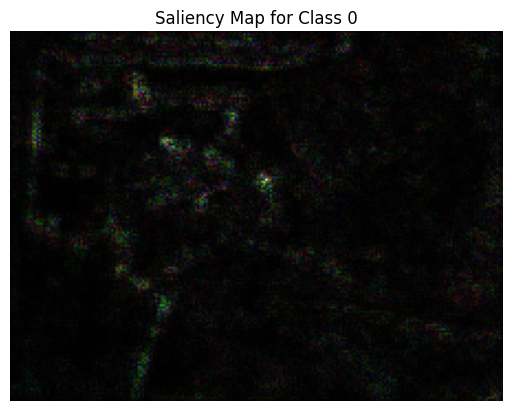

In [72]:
# Example usage
image, label = full_dataset[1]  # Get an image from your dataset
generate_saliency_map(model, image, target_class=0)


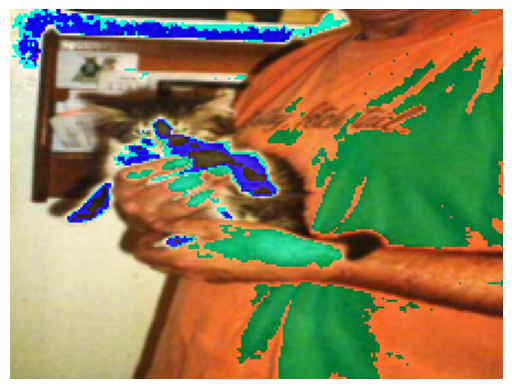

In [73]:
# Convert to PIL image
to_pil = transforms.ToPILImage()
image_pil = to_pil(image)

# Display the image using matplotlib
plt.imshow(image_pil)
plt.axis('off')  # Hide the axes
plt.show()

torch.Size([1, 64, 21, 28])


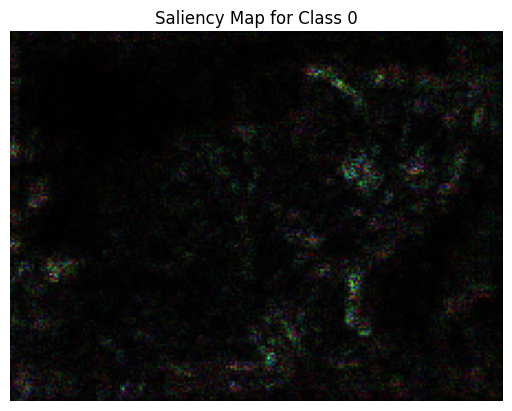

In [74]:
# Example usage
image, label = full_dataset[2]  # Get an image from your dataset
generate_saliency_map(model, image, target_class=0)



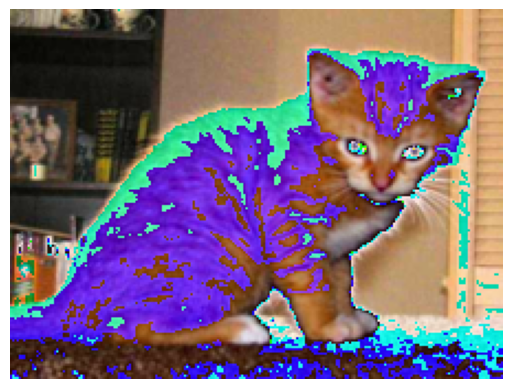

In [75]:
# Convert to PIL image
to_pil = transforms.ToPILImage()
image_pil = to_pil(image)

# Display the image using matplotlib
plt.imshow(image_pil)
plt.axis('off')  # Hide the axes
plt.show()

torch.Size([1, 64, 21, 28])


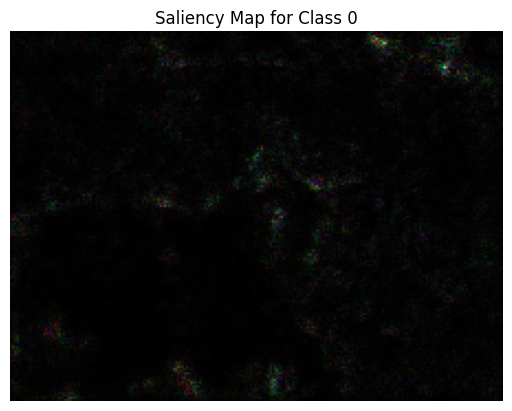

In [76]:
# Example usage
image, label = full_dataset[3]  # Get an image from your dataset
generate_saliency_map(model, image, target_class=0)


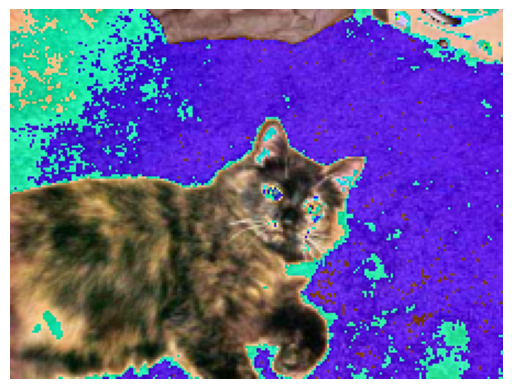

In [77]:
# Convert to PIL image
to_pil = transforms.ToPILImage()
image_pil = to_pil(image)

# Display the image using matplotlib
plt.imshow(image_pil)
plt.axis('off')  # Hide the axes
plt.show()

torch.Size([1, 64, 21, 28])


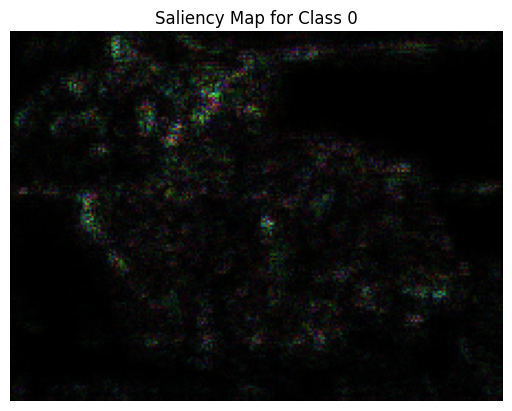

In [86]:
# Example usage
image, label = full_dataset[4]  # Get an image from your dataset
generate_saliency_map(model, image, target_class=0)


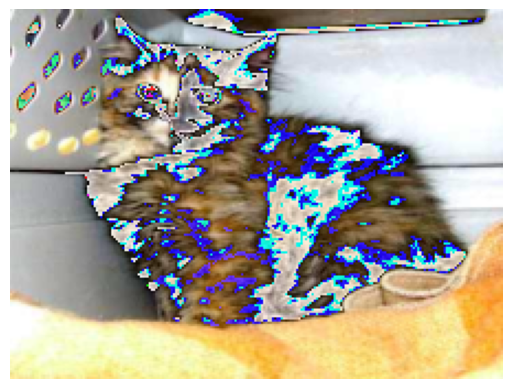

In [87]:
# Convert to PIL image
to_pil = transforms.ToPILImage()
image_pil = to_pil(image)

# Display the image using matplotlib
plt.imshow(image_pil)
plt.axis('off')  # Hide the axes
plt.show()

Let's try now to visualize again convolutional activation maps, but on cats and dogs images

In [88]:
def load_image(image_path, target_size=(168, 224)):
    img = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(target_size),  # Resize to model's input size
        transforms.ToTensor(),           # Convert to tensor (0-1 range)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img, img_tensor

In [96]:
def visualize_filter(model, image_path, layer_name, filter_idx):
    # Load image
    original_img, img_tensor = load_image(image_path)

    # Dictionary to store activations
    activations = {}

    # Hook to capture the output of the specified layer
    def hook_fn(module, input, output):
        activations[layer_name] = output.detach()

    # Register hook to the specified layer
    layer = getattr(model, layer_name)
    handle = layer.register_forward_hook(hook_fn)

    # Set model to evaluation mode and forward pass
    model.eval()
    with torch.no_grad():
        model(img_tensor)  # Run the image through the model

    # Remove the hook
    handle.remove()

    # Get the activation map for the specified filter
    activation_map = activations[layer_name][0, filter_idx].cpu().numpy()  # [C, H, W] -> [H, W] for filter_idx

    # Plotting
    plt.figure(figsize=(12, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    # Activation map
    plt.subplot(1, 2, 2)
    im = plt.imshow(activation_map, cmap='viridis')
    plt.title(f"{layer_name} Filter {filter_idx} Activation")
    plt.axis('off')

    # Add a color bar to show the activation range
    cbar = plt.colorbar(im, ax=plt.gca())
    cbar.set_label('Activation Value')

    plt.show()

torch.Size([1, 64, 21, 28])


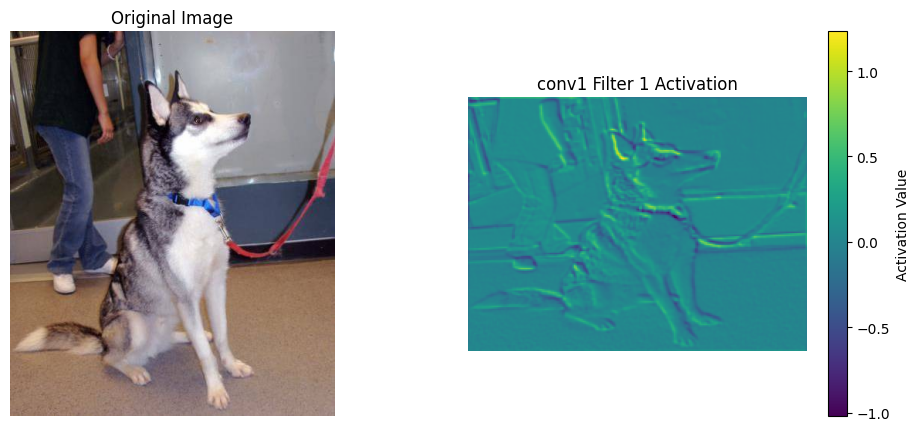

In [103]:
visualize_filter(model=model,
                 image_path=r"document_classification\document_classification\dogs\dog.4001.jpg",
                 layer_name="conv1",
                 filter_idx=1)

torch.Size([1, 64, 21, 28])


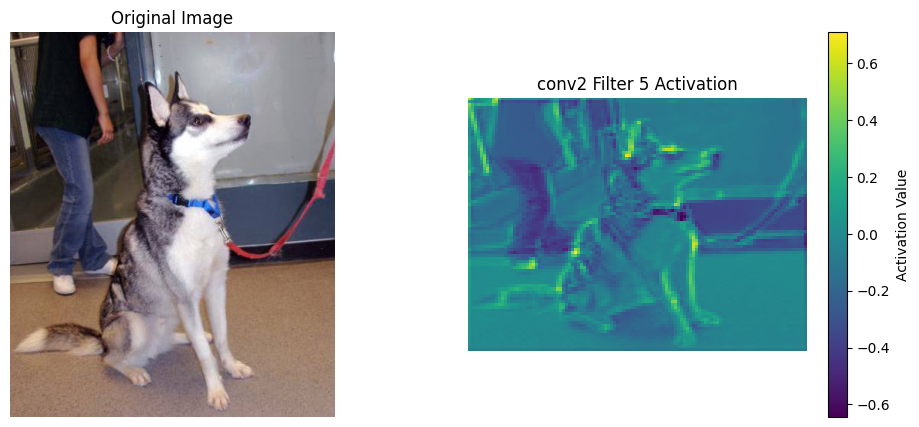

In [108]:
visualize_filter(model=model,
                 image_path=r"document_classification\document_classification\dogs\dog.4001.jpg",
                 layer_name="conv2",
                 filter_idx=5)

torch.Size([1, 64, 21, 28])


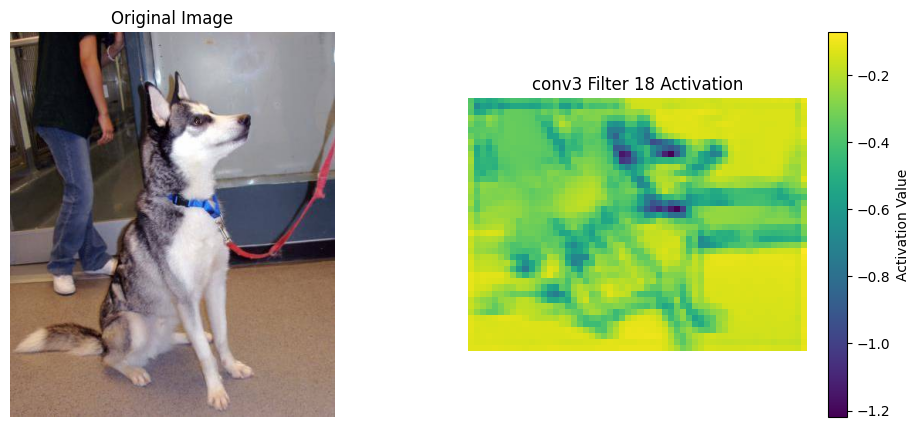

In [126]:
visualize_filter(model=model,
                 image_path=r"document_classification\document_classification\dogs\dog.4001.jpg",
                 layer_name="conv3",
                 filter_idx=18)

In [132]:
def visualize_fc_output_with_saliency(model, image_path, target_class_idx):
    # Load image
    original_img, img_tensor = load_image(image_path)

    # Set model to evaluation mode
    model.eval()

    # Ensure requires_grad=True for input image tensor
    img_tensor.requires_grad_()

    # Forward pass to get the output
    output = model(img_tensor)

    # Target class score (for the desired class)
    target_score = output[0, target_class_idx]

    # Backward pass to get the gradients of the target class with respect to the input image
    model.zero_grad()
    target_score.backward()

    # Get the absolute gradients for each pixel
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)  # [1, C, H, W] -> [H, W] (max across color channels)

    # Convert saliency map to numpy array
    saliency = saliency.squeeze().cpu().numpy()  # Remove batch dimension

    # Plotting
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    # Output of the fully connected layer (desired class output)
    plt.subplot(1, 3, 2)
    class_scores = output.detach().cpu().numpy().squeeze()
    plt.bar(range(len(class_scores)), class_scores)
    plt.title(f"FC Output (Class {target_class_idx})")
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(range(len(class_scores)))

    # Saliency map
    plt.subplot(1, 3, 3)
    plt.imshow(saliency, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')

    plt.show()

torch.Size([1, 64, 21, 28])


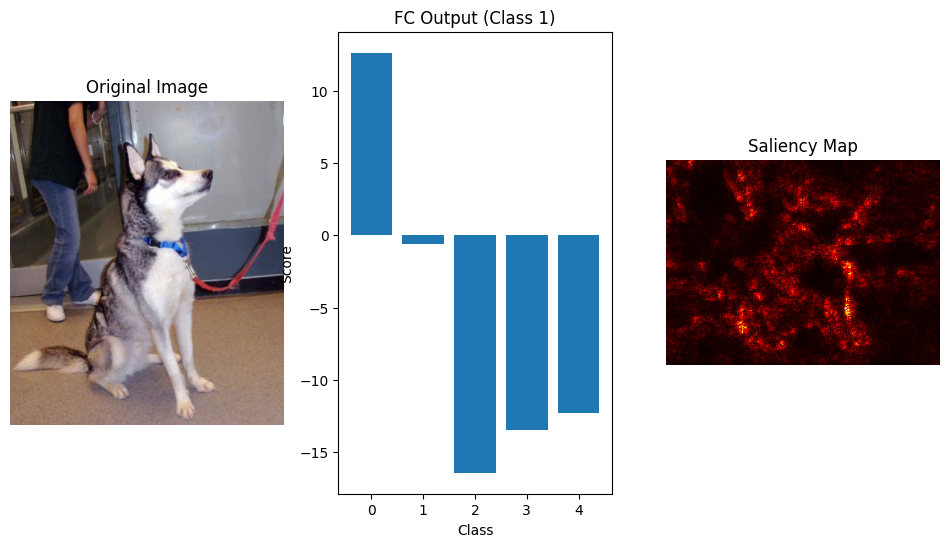

In [138]:
visualize_fc_output_with_saliency(
    model=model,
    image_path=r"document_classification\document_classification\dogs\dog.4001.jpg",
    target_class_idx=1
)